# Progetto architettura dati

Si vuoule leggere un dataset di applicazioni android, ogni aplicazione è etichettata come "goodware" o "malware" e le feature del dataset sono i permessi richiesti nel manifest dell'applicazione / alcune api call fatte dall'app.

Si vogliono sviluppare i seguenti 2 punti:
1. dimostrare che è possibile predirre correttamente se un applicazione è un malware o goodware in base ai permessi e le api call
2. verificare come cambiano le performance sporcando i dati all'interno del dataset

In [38]:
# import delle librerie necessarie
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans Nabataean, Nimbus Sans, Nimbus Roman'

# split dataset in train and test set
from sklearn.model_selection import train_test_split

# logistic regression model
from sklearn.linear_model import LogisticRegression

# RFECV
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer

# make random numbers
from random import randint


## Caricare il dataset

Si parte da un dataset con le seguenti feature:
- colonna 1->214: Permission-based features -> sono tutte feature binarie 0=permesso non richiesto, 1=permesso richiesto
- colonna 215->241: API based features -> sono tutte feature binarie 0=api call non richiesta, 1=api call richiesta
- colonna 242: label (target), dove le classi sono:
    - Malware 
    - Goodware

In [39]:
# Lettura del dataset
dataset = pd.read_csv('Dataset/TUANDROMD.csv')

In [40]:
# Mi salvo target e features in variabili diverse
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

print(uni_target)

         Label
0      malware
1      malware
2      malware
3      malware
4      malware
...        ...
4460  goodware
4461  goodware
4462  goodware
4463  goodware
4464  goodware

[4465 rows x 1 columns]


## Data Exploration
Come primo step controlliamo la numerosità del dataset.

In [41]:
# Mi salvo in una variabile il numero di features per dopo
n_features0 = dataset.shape[1] - 1

# Stampo il numero di records e di features
print(f'Ci sono {dataset.shape[0]} istanze ed un totale di {n_features0} features!')

Ci sono 4465 istanze ed un totale di 241 features!


### Dataset sbilanciato?

Il dataset è sbilanciato? proviamo a fare un **analisi univariata** sui valori di Label per verificare:

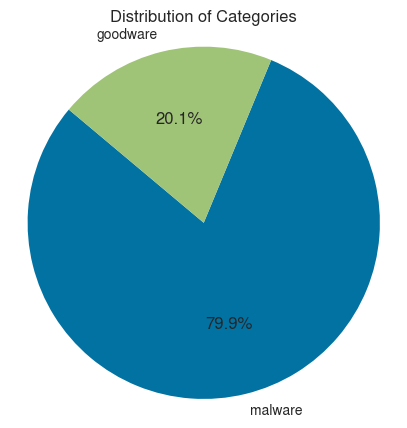

In [42]:
# Conta le occorrenze per ogni valore di Label
label_counts = uni_target['Label'].value_counts()

# Visualizzali in un piechart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')
plt.show()

Per quanto possa non piacerci molto la notizia che il dataset sia sbilanciato (può comportare degli errori bias nella classificazione dei modelli) abbiamo però la buona notizia della sicurezza che il data-set sia binario. 

Sarà quindi necessario utilizzare modelli che offrono buone prestazioni su dataset binari e non troppo suscettibili a dataset sbilanciati. Inoltre **poiché questo set di dati è fortemente sbilanciato, non dobbiamo utilizzare l'accuratezza come parametro di valutazione**, sarebbe meglio invece usare l'F1-score

### Valori mancanti?
Controlliamo ora se il dataset contiene valori mancanti

In [43]:
null_count_features = np.count_nonzero(uni_feature.isna().sum())
print(f"in totale ci sono {null_count_features}/241 features con valori mancanti")

in totale ci sono 241/241 features con valori mancanti


sembra che **tutte** le features contengano almeno un valore nullo.

sviluppiamo quindi una funzione che ci andrà ad elencare tutte le features con valori mancanti in ordine decrescente:

In [44]:
def conteggio_valori_nulli_per_colonna(df):
    colonne_con_valori_nulli = df.columns[df.isnull().any()]
    conteggio_valori_nulli = [(colonna, df[colonna].isnull().sum()) for colonna in colonne_con_valori_nulli]
    conteggio_valori_nulli_sorted = sorted(conteggio_valori_nulli, key=lambda x: x[1], reverse=True)
    
    for colonna, num_valori_nulli in conteggio_valori_nulli_sorted:
        print(f"Colonna '{colonna}': {num_valori_nulli} valori nulli")
        if num_valori_nulli > 0:
            print("Record con valori nulli:")
            records_con_null = df[df[colonna].isnull()]
            for index, row in records_con_null.iterrows():
                print(f"Indice: {index}, Valori: {row.to_dict()}")

In [45]:
print(conteggio_valori_nulli_per_colonna(dataset))

Colonna 'ACCESS_ALL_DOWNLOADS': 1 valori nulli
Record con valori nulli:
Indice: 2533, Valori: {'ACCESS_ALL_DOWNLOADS': nan, 'ACCESS_CACHE_FILESYSTEM': nan, 'ACCESS_CHECKIN_PROPERTIES': nan, 'ACCESS_COARSE_LOCATION': nan, 'ACCESS_COARSE_UPDATES': nan, 'ACCESS_FINE_LOCATION': nan, 'ACCESS_LOCATION_EXTRA_COMMANDS': nan, 'ACCESS_MOCK_LOCATION': nan, 'ACCESS_MTK_MMHW': nan, 'ACCESS_NETWORK_STATE': nan, 'ACCESS_PROVIDER': nan, 'ACCESS_SERVICE': nan, 'ACCESS_SHARED_DATA': nan, 'ACCESS_SUPERUSER': nan, 'ACCESS_SURFACE_FLINGER': nan, 'ACCESS_WIFI_STATE': nan, 'activityCalled': nan, 'ACTIVITY_RECOGNITION': nan, 'ACCOUNT_MANAGER': nan, 'ADD_VOICEMAIL': nan, 'ANT': nan, 'ANT_ADMIN': nan, 'AUTHENTICATE_ACCOUNTS': nan, 'AUTORUN_MANAGER_LICENSE_MANAGER': nan, 'AUTORUN_MANAGER_LICENSE_SERVICE(.autorun)': nan, 'BATTERY_STATS': nan, 'BILLING': nan, 'BIND_ACCESSIBILITY_SERVICE': nan, 'BIND_APPWIDGET': nan, 'BIND_CARRIER_MESSAGING_SERVICE': nan, 'BIND_DEVICE_ADMIN': nan, 'BIND_DREAM_SERVICE': nan, 'BIND_G

Ma in seguito ad un analisi più approfondita (tramite il richiamo della funzione appena definita) ci accorgiamo che è solo la riga 2533 ad avere valori nulli, possiamo dunque eliminarla dal dataset (in quanto non fornisce nessun valore infromativo, tutte le sue feature sono nulle)

In [46]:
# Visto che abbiamo appurato che solo la riga 2533 contiene valori nulli possiamo droppare "tutte" le righe con valori nulli
# mettiamo poi a paragone con il dorppare solo la riga 2533
# se questa operazione torna true abbiamo ulteriore conferma che solo la riga 2533 conteneva valori nulli
print ( dataset.dropna().equals( dataset.drop(2533)) )

True


Dato che l'operazione ritorna true allora possiamo definitivamente eliminare la riga dal dataset e ri-inizializzare le variabili di:
- dataset
- features
- target

In [47]:
dataset = dataset.dropna()
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

### Correlazione con il target?

Esploriamo alla ricerca di colonne con un altro coefficiente di Pearson.

Il coefficiente di correlazione di Pearson ha valori compresi tra -1 e 1
- Un valore più vicino allo 0 implica una correlazione più debole (0 esatto implica nessuna correlazione)
- Un valore più vicino a 1 implica una correlazione positiva più forte
- Un valore più vicino a -1 implica una correlazione negativa più forte


Prima di tutto sostituisco nel target dei valori numerici 0 ed 1 alle stringhe "goodware" e "malware"

In [48]:
uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])
print(uni_target)

      Label
0         0
1         0
2         0
3         0
4         0
...     ...
4460      1
4461      1
4462      1
4463      1
4464      1

[4464 rows x 1 columns]


/tmp/ipykernel_101379/3689904158.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])


Poi definiamo una funzione per trovare le colonne che hanno correlazione con il target superiore a 70% (se ce ne sno): 

In [49]:
def corrwith_target(feature, target, threshold):

    dummy_set = feature.copy()
    dummy_set['Label'] = target

    cor = dummy_set.corr()
    # Calcolo Correlazione con il target
    cor_target = abs(cor['Label'])
    # Seleziona le features correlate
    relevant_features = cor_target[cor_target>threshold]
    # Ordina in ordine decrescente
    relevant_features = relevant_features.sort_values(ascending=False)
    print(relevant_features)
    return relevant_features.index.tolist()[:-1]

In [50]:
corrwith_target(feature=uni_feature, target=uni_target, threshold=0.70)

Label                             1.000000
RECEIVE_BOOT_COMPLETED            0.760417
Ljava/net/URL;->openConnection    0.712211
Name: Label, dtype: float64


['Label', 'RECEIVE_BOOT_COMPLETED']

## Baseline e Modello di validazione

Paradossalmente per vedere se stiamo preparando i dati bene dobbbiamo testare le operazioni di shredding delle feature dataset su dei modelli giocattolo per valutare le performance della feature selection che vengono fatte passo passo, giusto per avere conferma che non stiamo peggiorando le performance della classificazione eleminando troppe fatures.

Nota: siccome stiamo usando un data-set sbilanciano è bene se ci basiamo sull' F1-score invece che sull'accuracy. 

Nota2: si scieglie appositamente di usare 2 modelli per la classificazione dei dati:
- **Logistic Regression**: un modello molto ben prestante alla presenza di un dataset sbilanciato e con molte feature (che quindi ci aspettiamo funzioni molto bene fin da subito)
- **Naive bayes**: un modello molto soggetto a bias, specialmente quando il dataset è sbilanciato (che ci aspettiamo quindi performi male prima di scolgere la preparazione dati)

In [51]:
# standard scaler
from sklearn.preprocessing import StandardScaler

# to keep track of training time
import datetime

# logistic regression - naive bayes model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt

# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix

# KNN imputation
from sklearn.impute import KNNImputer

# normalizer
from sklearn.preprocessing import Normalizer

# variance threshold
from sklearn.feature_selection import VarianceThreshold

Generiamo le prime variabili di train e test per valutare conme si comportano i modelli scelti se messi ad apprendere direttamente sul dataset senza nessuna lavorazione

In [52]:
X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.20, random_state=42, stratify=uni_target)

In [53]:
# Si può usare questa stessa funzione sia per trainare il modello che fare la valutazione di nuovi dati
# Per fare fare valutazione di nuovi dati basta mettere l'ultima feature a nulll
def evaluate_with_Logistic_Regression(test_df,  test_target, train_df=None, train_target=None, already_trained_model=None):
    
    # Standard scaling --> non necessario in quanto tutte le nostre feature sono binarie
    
    print("==========================================================================================================")
    print("")
    print(" _                 _     _   _        _____                              _             ")
    print("| |               (_)   | | (_)      |  __ \                            (_)             ")
    print("| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  ")
    print("| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ ")
    print("| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |")
    print("|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|")
    print("              __/ |                               __/ |                                ")
    print("             |___/                               |___/                                ")

    start_time = datetime.datetime.now()

    logreg = already_trained_model
    # Check if the model is already trained, if yes, train it
    if(already_trained_model is None):
        # Logistic Regression model
        logreg = LogisticRegression(random_state=42, class_weight='balanced', C=200, dual=False, solver='liblinear')
        logreg.fit(train_df, train_target.values.ravel())
    
    # Evaluation and scoring for Logistic Regression
    y_pred_logreg = logreg.predict(test_df)
    y_true = test_target.values.ravel()
    f1score_logreg = f1_score(y_true, y_pred_logreg, average='micro')
    mccscore_logreg = matthews_corrcoef(y_true, y_pred_logreg)
    precision_logreg = precision_score(y_true, y_pred_logreg, average='micro')

    # Evaluete total train + evaluation time
    elapsed = datetime.datetime.now() - start_time
    time = int(elapsed.total_seconds()*1000)
    
    # Visualizations for Logistic Regression
    cre_logreg = ClassPredictionError(logreg, classes=['malware', 'goodware'])
    cre_logreg.score(test_df, y_true)
    cre_logreg.show()
    
    cm_logreg = ConfusionMatrix(logreg, classes=['malware', 'goodware'])
    cm_logreg.score(test_df, y_true)
    cm_logreg.show()
    
    rocauc_logreg = RocCurveDisplay.from_estimator(logreg, test_df, y_true)
    plt.show()

    return {
        "logreg": {
            "model": logreg,
            "time": time,
            "f1score": f1score_logreg,
            "mccscore": mccscore_logreg,
            "precision": precision_logreg
        }
    }


In [54]:
def print_results_logreg(results_logreg):
    print("==========================================================================================================")
    print()
    print("Logistic Regression Results:")
    print(f"Time: {results_logreg['time']} ms")
    print(f"F1 Score: {results_logreg['f1score']:.2f}")
    print(f"MCC Score: {results_logreg['mccscore']:.2f}")
    print(f"Precision: {results_logreg['precision']:.2f}")
    print()
    print("==========================================================================================================")

In [55]:
# Si può usare questa stessa funzione sia per trainare il modello che fare la valutazione di nuovi dati
# Per fare fare valutazione di nuovi dati basta mettere l'ultima feature a nulll
def evaluate_with_Naive_Bayes(test_df,  test_target, train_df=None, train_target=None, already_trained_model=None):
    
    # Standard scaling --> non necessario in quanto tutte le nostre feature sono binarie

    print("==========================================================================================================")
    print("")
    print(" _   _       _             ____                        ")
    print("| \ | |     (_)           |  _ \                       ")
    print("|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ ")
    print("| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|")
    print("| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ ")
    print("|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/")
    print("                                        __/ | ")
    print("                                       |___/ ")
    
    start_time = datetime.datetime.now()    

    nb = already_trained_model
    # Check if the model is already trained, if no, train it
    if(already_trained_model is None):
        # Naive Bayes model
        nb = GaussianNB()
        nb.fit(train_df, train_target.values.ravel())
    
    # Evaluation and scoring for Naive Bayes
    y_true = test_target.values.ravel()
    y_pred_nb = nb.predict(test_df)
    f1score_nb = f1_score(y_true, y_pred_nb, average='micro')
    mccscore_nb = matthews_corrcoef(y_true, y_pred_nb)
    precision_nb = precision_score(y_true, y_pred_nb, average='micro')

    # Evaluete total train + evaluation time
    elapsed = datetime.datetime.now() - start_time
    time = int(elapsed.total_seconds()*1000)
    
    # Visualizations for Naive Bayes
    cre_nb = ClassPredictionError(nb, classes=['malware', 'goodware'])
    cre_nb.score(test_df, y_true)
    cre_nb.show()
    
    cm_nb = ConfusionMatrix(nb, classes=['malware', 'goodware'])
    cm_nb.score(test_df, y_true)
    cm_nb.show()
    
    rocauc_nb = RocCurveDisplay.from_estimator(nb, test_df, y_true)
    plt.show()

    return {
        "naive_bayes": {
            "model": nb,
            "time": time,
            "f1score": f1score_nb,
            "mccscore": mccscore_nb,
            "precision": precision_nb
        }
    }

In [56]:
def print_results_nb(results_nb):    
    
    print("==========================================================================================================")
    print()
    print("Naive Bayes Results:")
    print(f"Time: {results_nb['time']} ms")
    print(f"F1 Score: {results_nb['f1score']:.2f}")
    print(f"MCC Score: {results_nb['mccscore']:.2f}")
    print(f"Precision: {results_nb['precision']:.2f}")
    print()
    print("==========================================================================================================")

In [57]:
# Funzione che chiama contemporaneamente sia il train di LogReg che NaiveBayes
def evaluate(X_train, X_test, y_train, y_test):

    results_logreg = evaluate_with_Logistic_Regression(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)["logreg"]
    results_nb = evaluate_with_Naive_Bayes(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)["naive_bayes"]

    print_results_logreg(results_logreg)
    print()
    print()
    print_results_nb(results_nb)

    return results_logreg, results_nb

Nota che nel blocco seguente si salvano nelle variabili:
- `trained_logreg_full` : il Logistic Regressio addestrato su tutte le feature
- `trained_nb_full` : il modello Naive Bayes addestrato su tutte le feature

Queste variabili saranno i nostri **BASELINE MODEL** per le operazioni di valutazione che richiedono tutte le colonne del dataset


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


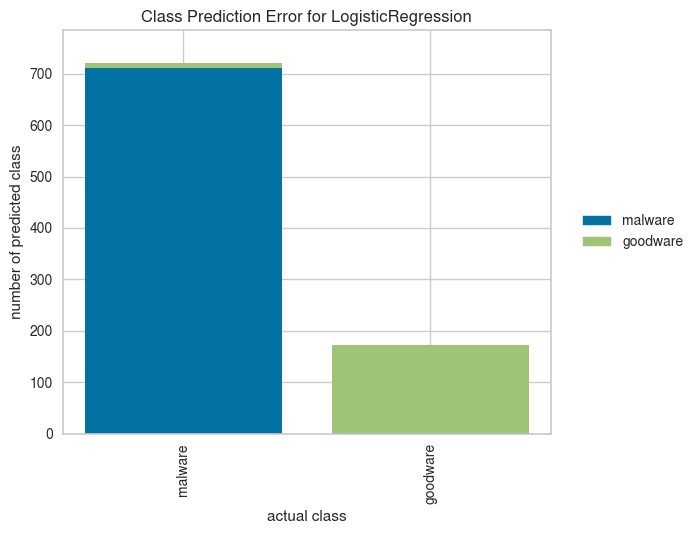

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


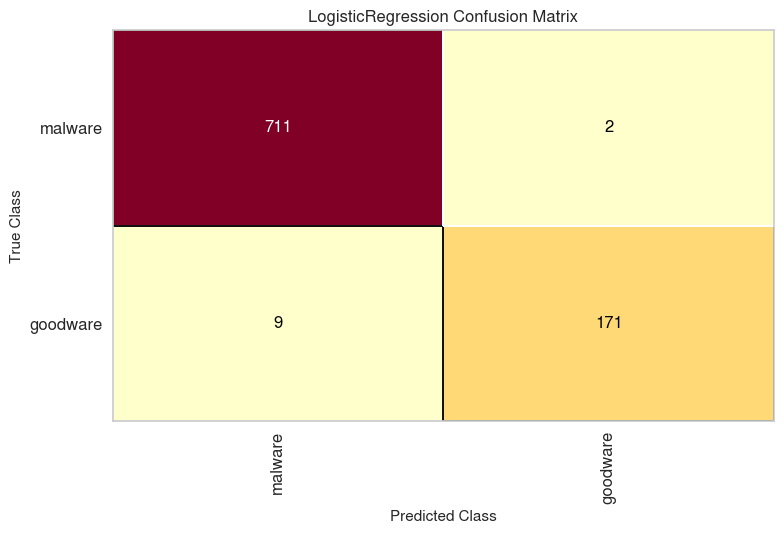

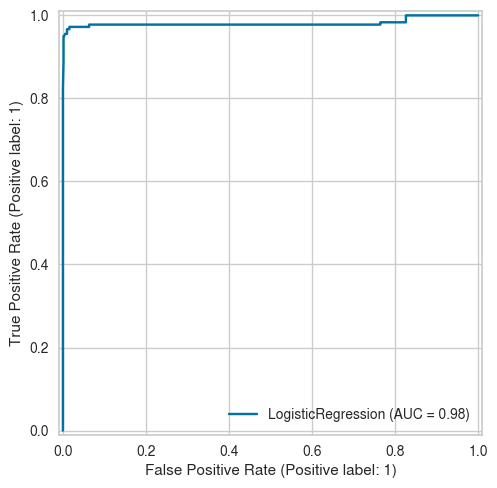


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


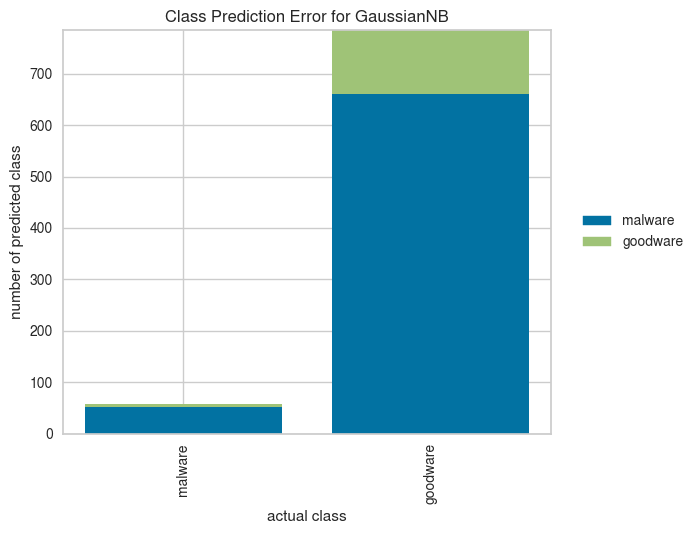

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


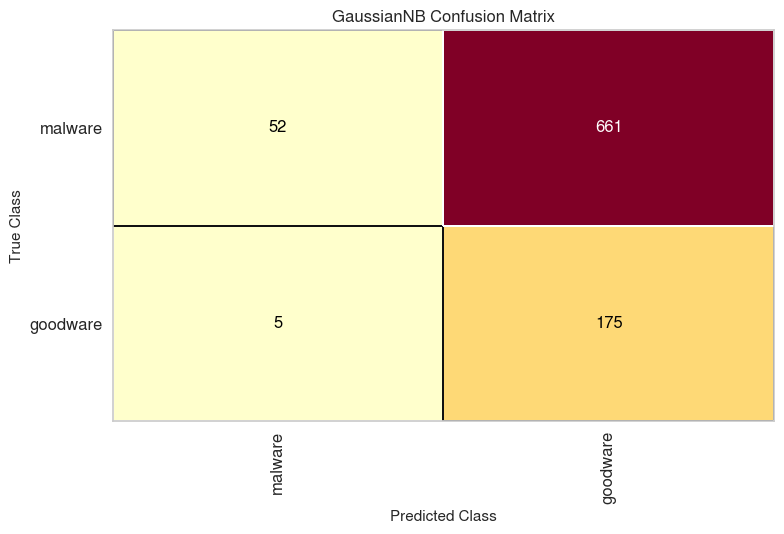

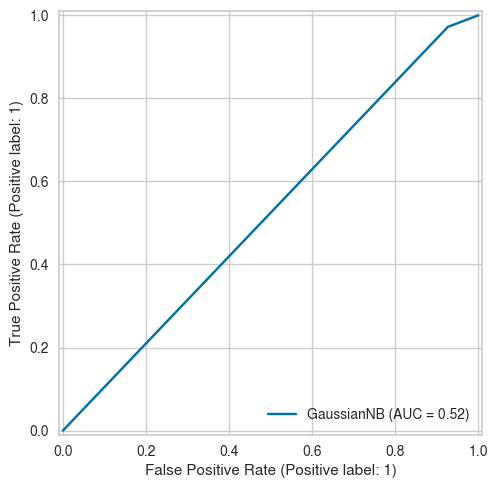


Logistic Regression Results:
Time: 48 ms
F1 Score: 0.99
MCC Score: 0.96
Precision: 0.99




Naive Bayes Results:
Time: 18 ms
F1 Score: 0.25
MCC Score: 0.07
Precision: 0.25



In [58]:
result_lr_baseline_full, result_nb_baseline_full = evaluate(X_train, X_test, y_train, y_test)
trained_logreg_full, trained_nb_full = result_lr_baseline_full["model"], result_nb_baseline_full["model"]

Dai plot appena mostrati riusciamo a concludere che nonostante ci siamo molte features, riusciamo comunque a valture tutto il dataset in tempi accettabili.
Questo ci piace anche se siamo a conoscenza del fatto che dovessimo avere più istanze nel nostro dataset il tempo di predizione non scalerebbe per niente bene. Siccome noi però non dobbiamo fare altro che creare un modello giocattolo per vedere se eliminando alcune feature dal dataset riusciamo a mantenere lo f1-score questa cosa ci va bene.

Inoltre, esattamente come ci aspettavamo, spicca molto la differenza di performance di classificazzione dei due algoritmi: laddove la logistic regression fin da subito riesce ad ottenere degli ottimi risultati di classificazione (che rasentano il classificatore perfetto) invece il modello naive bayes, come ci aspettavamo, diventa un classificatore casuale. 

## Preparazione dei dati: Feature selection

In questa fase andremo a dimostrare come pulire i dati, in particolar modo fare feature extraction per far rimanere solo le feature più importanti alla classificazione, possa migliorare moltissimo le prestazioni del modello naive bayes (rendendolo più simile al modello di regressione logistica a) ed inoltre anche velicizzare di molto entrambi i tempi di predizione per entrambi i modelli (rendendo le soluzioni più scalabili)

Si noti però che questo non è il nostro fine ultimo. Noi vogliamo fare feature extracion delle feature più importanti per poi andare a sperimentare come i due modelli si dovessero comportare nel caso in cui queste feature venissero "sporcate" (passaggio che verrà eseguito nella sezione successiva)

Si nota inoltre che per verificare che stiamo facendo un buon lavoro di estrazione delle feature è necessario trainare da capo i modelli precedentemente visti ad ogni passaggio di feature extraction eseguito. Ci salveremo poi solo l'ultima versione dei modelli che sono in grado di valutare i dati leggendo solo le feature più importanti di tutto il dataset; ossia i **BASELINE MODEL** per il dataset contenente solo le feature più importanti

In [59]:
# Per la prima operazione di selezione delle feature partiamo dall'avere tutte le feature come feature più importanti
most_important_features = uni_feature

### Analisi bivariata della correlazione - Eliminazione feature ridondanti

Se due features non sono indipendenti l'una dall'altra hanno una correlazione assoluta elevata e le informazioni che offrono per il nostro modello ML sono sostanzialmente le stesse.

Le features correlate in generale non migliorano i modelli, quindi se ne può eliminarne una, in quanto è ridondante. Con la seguente funzione possiamo selezionare feature altamente correlate (correlate ad un altra feature al 95%)

In [60]:
# nota: la funzione seleziona la PRIMA feature correlata a qualsiasi altra feature
def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # siamo interessati al valore assoluto del coeff
                colname = corr_matrix.columns[i]  # si prende la stringa del nome della colonna
                col_corr.add(colname)
    return col_corr

**Nota**: calcoliamo prima la divisione in train e test set perchè volgiamo applicare il metodo di eliminazione delle feature ridondanti appena definito **solo sul train set** per poi verificare, tramite validazione con i modelli, produca buoni risulati anche sul test set. Se si andasse immediatamente ad applicare la rimozione della feature direttamente su tutto il dataset si causerebbe overfitting.

Seguriemo questa prcedura di divisione del dataset di `most_important_features` in train e test per validare le performance su anche tutte le elaborazioni seguenti

In [61]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.20, random_state=42, stratify=uni_target)

In [62]:
non_correlated_features = correlation(X_train, 0.95) #da qui si imposta che voglio threshold di correlazione minimo 95%
# Ossia tutte le feature che sono correlate ad un altra feature per almeno il 95% vengono eliminate

# Inizializzo variabile delle feature meno importanti
less_important_features = non_correlated_features

# Aggiornamento delle variabili di test e trai dopo aver calcolato le feature da droppare
X_train = X_train.drop(non_correlated_features, axis=1)
X_test = X_test.drop(non_correlated_features, axis=1)

n_correlated_features = X_train.shape[1]

print(f'Dopo aver droppato {len(non_correlated_features)} features, rimangono {n_correlated_features} features.')
print("Features droppate:")
print(non_correlated_features)

Dopo aver droppato 81 features, rimangono 160 features.
Features droppate:
{'SET_ORIENTATION', 'WRITE_HISTORY_BOOKMARKS', 'Ljava/lang/System;->loadLibrary', 'BLUETOOTH_PRIVILEGED', 'WRITE_USER_DICTIONARY', 'CAPTURE_SECURE_VIDEO_OUTPUT', 'FACTORY_TEST', 'USE_SIP', 'READ_VOICEMAIL', 'LOCATION_HARDWARE', 'WRITE_CALENDAR', 'BROADCAST_SMS', 'CONTROL_LOCATION_UPDATES', 'SET_WALLPAPER_HINTS', 'CALL_PRIVILEGED', 'SET_PREFERRED_APPLICATIONS', 'CAPTURE_AUDIO_OUTPUT', 'GLOBAL_SEARCH', 'REORDER_TASKS', 'DIAGgoodwareSTIC', 'BROADCAST_WAP_PUSH', 'ACCESS_SURFACE_FLINGER', 'DEVICE_POWER', 'READ_FRAME_BUFFER', 'SET_PROCESS_LIMIT', 'STATUS_BAR', 'CHANGE_CONFIGURATION', 'RECEIVE_WAP_PUSH', 'UNINSTALL_SHORTCUT', 'PERSISTENT_ACTIVITY', 'INTERNAL_SYSTEM_WINDOW', 'MANAGE_APP_TOKENS', 'WRITE_PROFILE', 'MEDIA_CONTENT_CONTROL', 'BIND_APPWIDGET', 'MOUNT_FORMAT_FILESYSTEMS', 'BIND_VPN_SERVICE', 'READ_SYNC_STATS', 'GET_TOP_ACTIVITY_INFO', 'BODY_SENSORS', 'READ_SOCIAL_STREAM', 'BIND_CARRIER_MESSAGING_SERVICE', 'SET


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


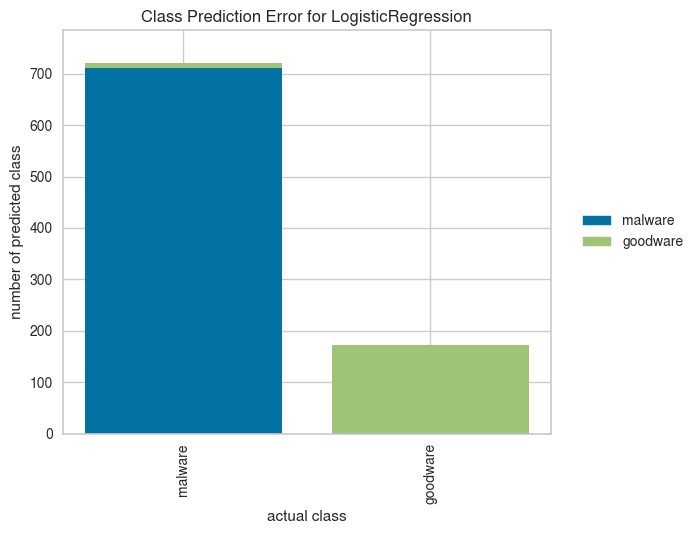

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


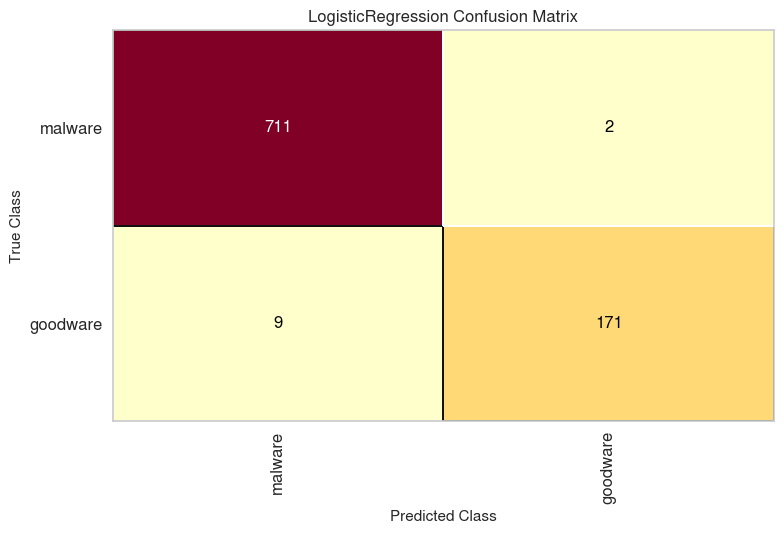

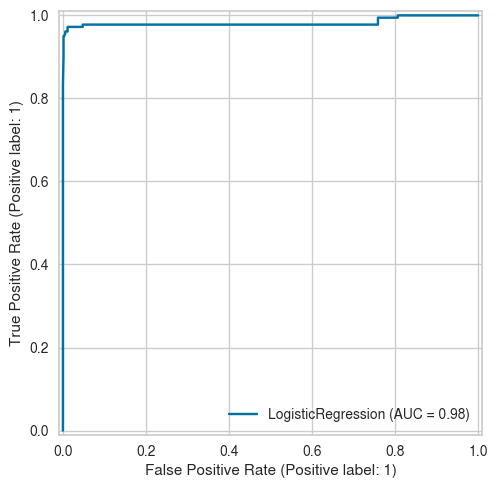


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


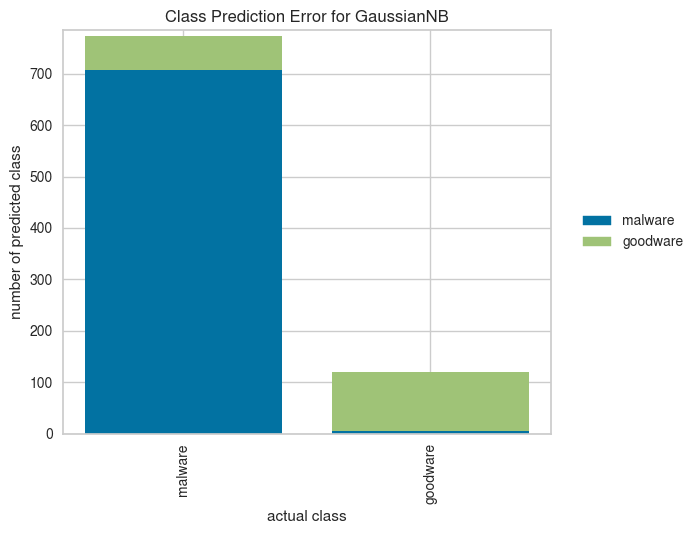

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


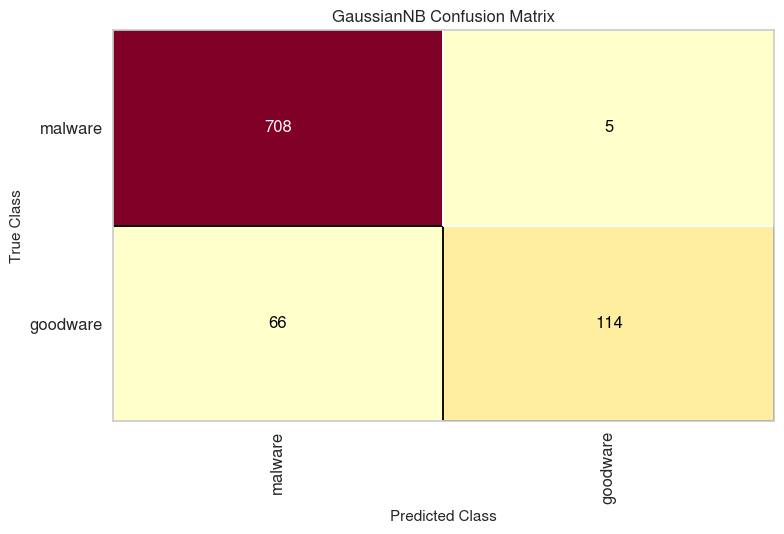

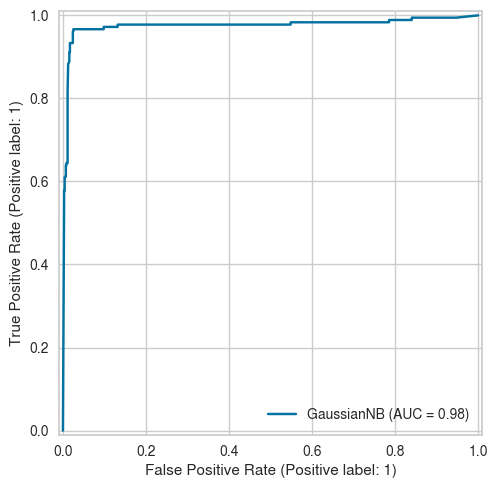


Logistic Regression Results:
Time: 44 ms
F1 Score: 0.99
MCC Score: 0.96
Precision: 0.99




Naive Bayes Results:
Time: 19 ms
F1 Score: 0.92
MCC Score: 0.74
Precision: 0.92



In [63]:
result_lr_baseline_important_features, result_nb_baseline_important_features = evaluate(X_train, X_test, y_train, y_test)
trained_logreg_important_features, trained_nb_important_feature = result_lr_baseline_important_features["model"], result_nb_baseline_important_features["model"]

Dato che abbiamo appurato che la funzione da buoni risultati possiamo aggironare quindi la variabile delle dataset di `most_important_features` (contente solo le fature più importanti) come segue:

In [64]:
# Inizializzazione varibile feature più importanti
most_important_features = most_important_features.drop(non_correlated_features, axis=1)
most_important_features_columns = most_important_features.columns

### Analisi bivariata della correlazione - Highlight delle feature più importanti

A differenza della correlazione a coppie vista prima, in cui è desiderabile una correlazione bassa tra due feature diverse, in questo caso vorremmo che le nostre features avessero un'elevata correlazione con il target. Se una feature ha una bassa correlazione con il target, significa che non è una funzionalità utile per prevedere il target e, pertanto, dovrebbe essere rimossa. 

La seguente funzione calcolerà la correlazione di ciascuna feature con il target e poi restituirà le colonne che hanno una correlazione inferiore alla soglia scelta.

In [65]:
def corrwith_target_less_that_threshold(dataframe, target, threshold):
    cor = dataframe.corr()
    # Calcolo Correlazione con il target
    cor_target = abs(cor[target])
    # Seleziona le features non correlate
    # se non supera la soglia 'threshold' passata come parametro si aggiunge la colonna all'elelenco di colonne da scartare
    irrelevant_features = cor_target[cor_target<threshold]
    return irrelevant_features.index.tolist()[:-1]

Di seguito, come anticipato, divisione del dataset di `most_important_features` in train e test per poi validare le performance della lavorazione che si vuole applicare: 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.20, random_state=42, stratify=uni_target)

In [67]:
# Si deve creare una variabile di test-set dummy (che contiene anche il target) per far girare il metodo appena creato
dummy_train = X_train.copy()
dummy_train['Label'] = y_train

In [68]:
#facciamo rimanere le colonne che hanno correlazione con il target superiore a 15%
corrwith_cols = corrwith_target_less_that_threshold(dummy_train, 'Label', 0.15) 

# Aggiunta delle feature meno importanti ritrovate a questo passaggio
less_important_features.update( corrwith_cols )

# Aggiornamento delle feature più importanti 
# (si droppano quelle meno importanti appena trovate da quelle most_important trovate precedentemente)
# Crea un set di nomi delle colonne più importanti
most_important_features_columns = set(most_important_features.columns)
# Trova l'intersezione tra most_important_features - corrwith_cols
common_columns = most_important_features_columns.intersection(corrwith_cols)

# Droppa le colonne da most_important_features se ce ne sono
if common_columns:
    X_train.drop(columns=common_columns, inplace=True)
    X_test.drop(columns=common_columns, inplace=True)

n_correlated_features = X_train.shape[1]

print(f'Dopo aver droppato in totale {len(less_important_features)} features, rimangono {n_correlated_features} features.')
print("Colonne droppate in questa operazione:")
print(corrwith_cols)

Dopo aver droppato in totale 165 features, rimangono 76 features.
Colonne droppate in questa operazione:
['ACCESS_ALL_DOWNLOADS', 'ACCESS_CACHE_FILESYSTEM', 'ACCESS_CHECKIN_PROPERTIES', 'ACCESS_COARSE_UPDATES', 'ACCESS_LOCATION_EXTRA_COMMANDS', 'ACCESS_MOCK_LOCATION', 'ACCESS_NETWORK_STATE', 'ACCESS_SUPERUSER', 'ACCESS_WIFI_STATE', 'ACCOUNT_MANAGER', 'AUTHENTICATE_ACCOUNTS', 'BATTERY_STATS', 'BILLING', 'BIND_ACCESSIBILITY_SERVICE', 'BIND_DEVICE_ADMIN', 'BIND_goodwareTIFICATION_LISTENER_SERVICE', 'BLUETOOTH_ADMIN', 'BRICK', 'BROADCAST_STICKY', 'C2D_MESSAGE', 'CALL_PHONE', 'CAMERA', 'CHANGE_COMPONENT_ENABLED_STATE', 'CHANGE_WIFI_MULTICAST_STATE', 'CHANGE_WIFI_STATE', 'CLEAR_APP_CACHE', 'CLEAR_APP_USER_DATA', 'DELETE_PACKAGES', 'DOWNLOAD_WITHOUT_goodwareTIFICATION', 'DUMP', 'EXPAND_STATUS_BAR', 'FLASHLIGHT', 'GET_ACCOUNTS', 'GET_PACKAGE_SIZE', 'HARDWARE_TEST', 'INSTALL_PACKAGES', 'INTERNET', 'MANAGE_ACCOUNTS', 'MASTER_CLEAR', 'MEDIA_BUTTON', 'MODIFY_AUDIO_SETTINGS', 'MODIFY_PHONE_STATE', 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


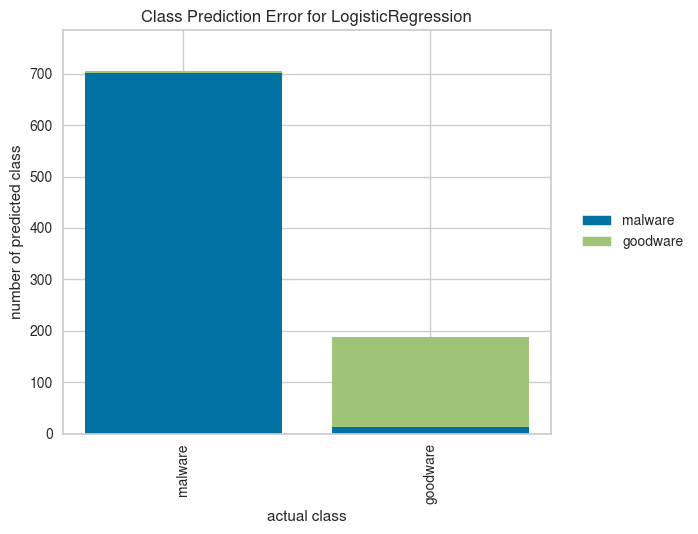

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


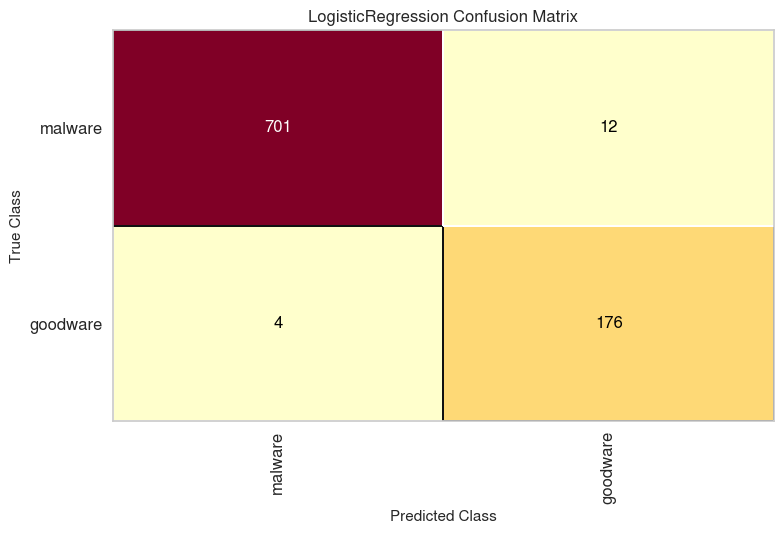

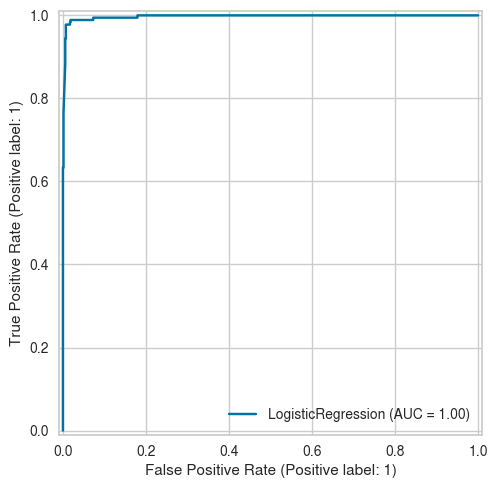


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


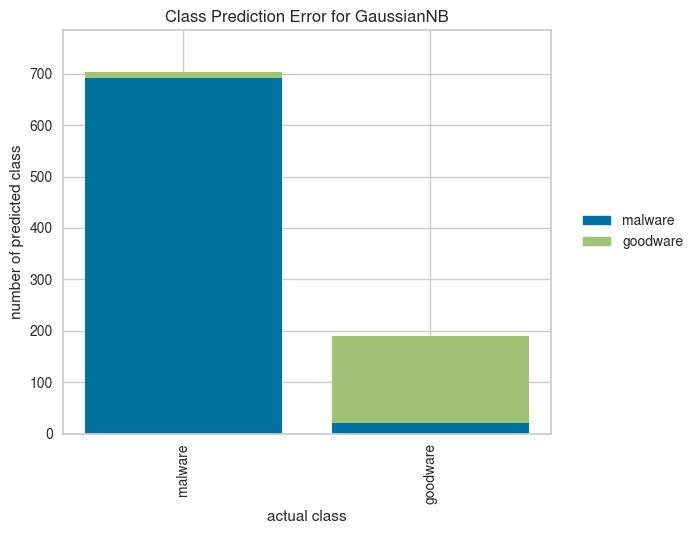

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


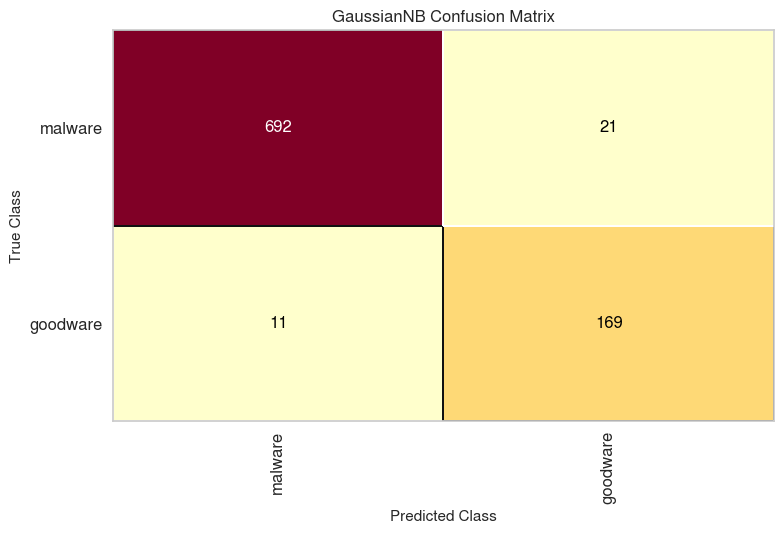

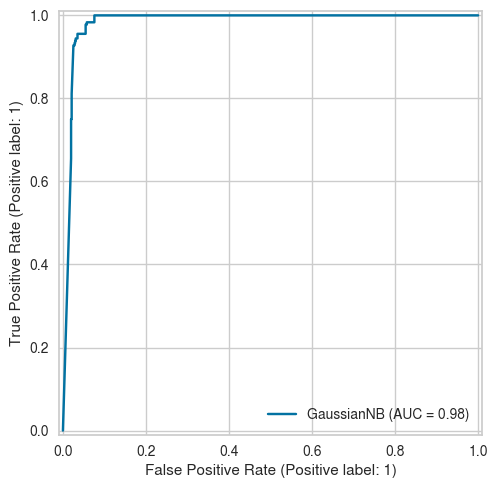


Logistic Regression Results:
Time: 27 ms
F1 Score: 0.98
MCC Score: 0.95
Precision: 0.98




Naive Bayes Results:
Time: 9 ms
F1 Score: 0.96
MCC Score: 0.89
Precision: 0.96



In [69]:
result_lr_baseline_important_features, result_nb_baseline_important_features = evaluate(X_train, X_test, y_train, y_test)
trained_logreg_important_features, trained_nb_important_feature = result_lr_baseline_important_features["model"], result_nb_baseline_important_features["model"]

In [70]:
# Dopo aver dimostrato il funzionamento possiamo droppare le colonne da most_important_features (che ricordiamo è una variabile contiene le istanze)
if common_columns:
    most_important_features.drop(columns=common_columns, inplace=True)

most_important_features_columns = most_important_features.columns

### RFE-CV (Recursive feature elimination)

RFE prende in input il modello al quale vogliamo applicare i dati ed il train set. Questa tecnica, come indica il nome, effettua le seguenti fasi:

1. **Selezione iterativa delle feature**: RFE opera selezionando iterativamente un sottoinsieme di feature dal dataset. Inizia con tutte le feature nel dataset e addestra il modello su di esse.

2. **Valutazione delle feature**: Dopo aver addestrato il modello, viene calcolata una metrica di importanza delle feature, che può essere basata su coefficienti (nel caso della regressione lineare, per esempio), importanza delle variabili (nel caso degli alberi decisionali) o altre metriche rilevanti per il tipo di modello utilizzato.

3. **Eliminazione delle feature meno importanti**: Dalle feature attualmente selezionate, RFE rimuove quelle che sono considerate meno importanti secondo la metrica di importanza definita.

4. **Valutazione delle prestazioni**: il modello viene valutato utilizzando il sottoinsieme ottimale di feature selezionate tramite RFE.

5. **Ripetizione**: Il processo viene ripetuto ricorsivamente con un numero inferiore di feature, continuando fino a raggiungere un numero prefissato di feature o fino a quando il miglioramento delle prestazioni del modello non è significativo.


Il vantaggio principale di RFE è che permette di ottenere un modello più semplice e interpretabile, mantenendo allo stesso tempo o migliorando le prestazioni predictive. Rimuovendo le feature meno informative, si riduce anche il rischio di overfitting, specialmente in presenza di un gran numero di feature rispetto al numero di osservazioni nel dataset. 

Tuttavia, è importante notare che RFE può richiedere un tempo di calcolo significativo, specialmente con dataset molto grandi e complessi (essendo un metodo ricorsivo non scala bene). Noi avremmo potuto applicare RFE fin da subito (senza applicare le elaborazioni precedenti) ma in quel caso i tempi di computazione sarebbero diventanti non accdetabili (intorno ai 40 minuti). Invece dopo la selezione che abbiamo effettuato abbiamo un elaborazione di RFE in circa 2 minuti, che è sempre tanto ma a noi va bene comunque perchè questo è un modello giocattolo

In [71]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.20, random_state=42, stratify=uni_target)

Nota: in questo caso noi applichiamo RFE per ottenere un miglioramento delle prestazioni solo sul modello di Logistic Regression per 3 motivi: 
1. Computare un miglioramento delle prestazioni su entrambi i modelli costerebbe troppo tempo
2. Se si ha un miglioramento sul modello di Logistic Regression lo si ha sicuramente anche sul modello Naive Bayes 
3. The GaussianNB does not offer an intrinsic method to evaluate feature importances. Naïve Bayes methods work by determining the conditional and unconditional probabilities associated with the features and predict the class with the highest probability. Thus, there are no coefficients computed or associated with the features you used to train the model 

Ma per essere pianamente sicuri, come sempre, applichiamo prima la trasformazione di RFE solo sul train set e validiamo i risultati facendo predizione con entrambi i modelli 

In [72]:
from sklearn.inspection import permutation_importance

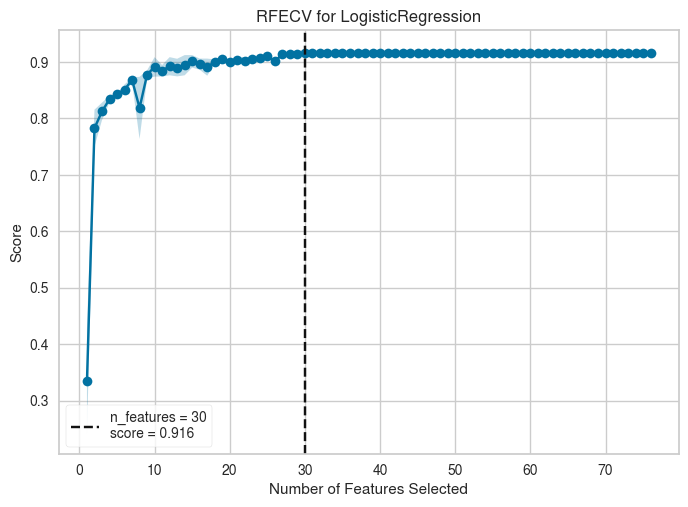

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [73]:
# Definire una funzione di scoring 
mcc_scorer = make_scorer(matthews_corrcoef)

# Creare un oggetto RFEC
rfecv = RFECV(estimator=LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),
              cv=StratifiedKFold(2),
              scoring =  mcc_scorer)

#Fit e visualizzazione feature selezionate
rfecv.fit(X_train, y_train.values.ravel())
rfecv.show() 

In [74]:
mask = rfecv.get_support()

#variabile tmp per avere tutte le colonne
columns = X_train.columns

#variabile con colonne selezionate / non selezionate da RFE 
# Aggiunta delle feature meno importanti ritrovate a questo passaggio
less_important_features.update( columns[~mask] ) 
most_important_features_columns = columns[mask]

# Aggiornamento delle variabili di test e trai dopo aver calcolato le feature da droppare
X_train = pd.DataFrame(rfecv.transform(X_train), columns = most_important_features_columns)
X_test = pd.DataFrame(rfecv.transform(X_test), columns = most_important_features_columns)

print(f'Dopo aver droppato in totale {len(less_important_features)} features, rimangono {X_train.shape[1]} features.')
print("Colonne droppate in questa operazione:")
print(less_important_features)

Dopo aver droppato in totale 211 features, rimangono 30 features.
Colonne droppate in questa operazione:
{'SET_ORIENTATION', 'WRITE_HISTORY_BOOKMARKS', 'Ljava/lang/System;->loadLibrary', 'RECEIVE_USER_PRESENT', 'BROADCAST_STICKY', 'BLUETOOTH_PRIVILEGED', 'READ_AVESTTINGS', 'READ_SMS', 'WRITE_USER_DICTIONARY', 'ACCESS_NETWORK_STATE', 'CAPTURE_SECURE_VIDEO_OUTPUT', 'ACCESS_COARSE_UPDATES', 'CALL_PHONE', 'FACTORY_TEST', 'USE_SIP', 'READ_VOICEMAIL', 'READ_PROFILE', 'LOCATION_HARDWARE', 'STORAGE', 'ACCESS_SERVICE', 'USES_POLICY_FORCE_LOCK', 'WRITE_CALENDAR', 'Landroid/hardware/Camera;->takePicture', 'BROADCAST_SMS', 'AUTORUN_MANAGER_LICENSE_SERVICE(.autorun)', 'CONTROL_LOCATION_UPDATES', 'Landroid/telephony/TelephonyManager;->getLine1Number', 'Ljava/lang/Runtime;->exec', 'SET_WALLPAPER_HINTS', 'CALL_PRIVILEGED', 'MODIFY_PHONE_STATE', 'DELETE_PACKAGES', 'activityCalled', 'SET_PREFERRED_APPLICATIONS', 'CHANGE_WIFI_MULTICAST_STATE', 'CAMERA', 'READ_CONTACTS', 'ACCESS_SUPERUSER', 'Ljavax/crypto

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(
/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


Come anticipato all'inizio del capitolo dopo aver applicato RFE e averne visualizzato gli ottimi risultati siamo ora pornti a salvarci i modelli trainati sul dataset le queli feature sono state selezionate a quelle più importanti:

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(



 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


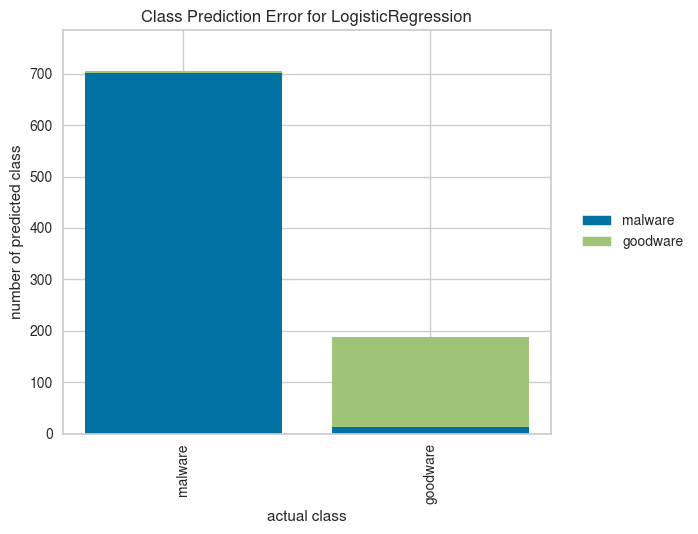

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


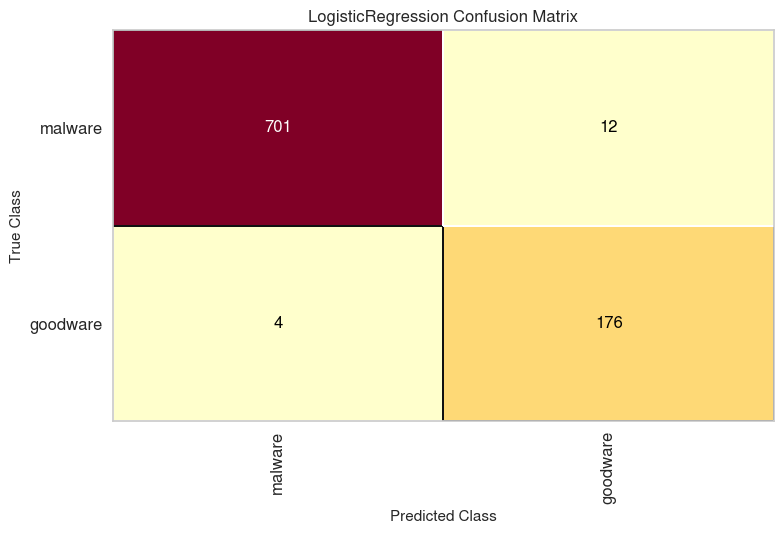

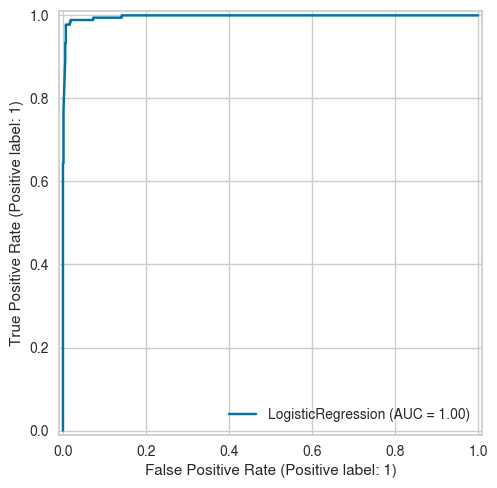


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


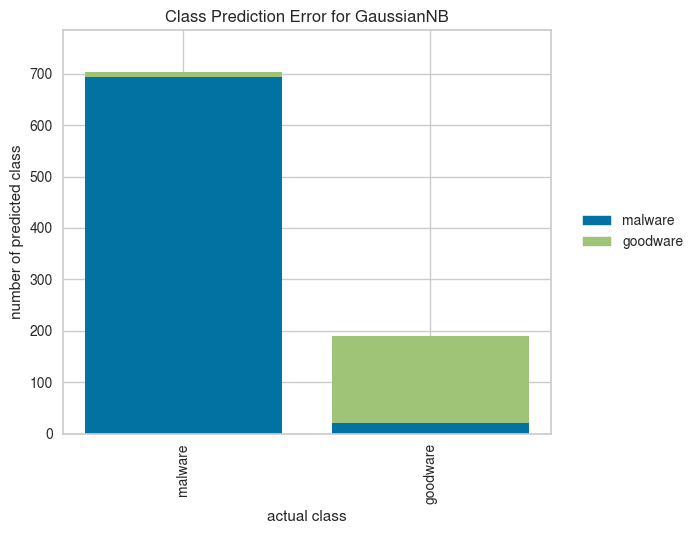

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


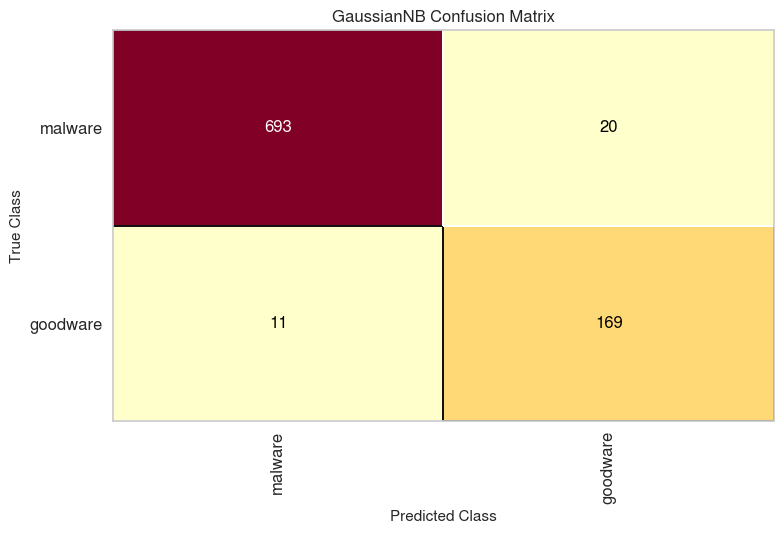

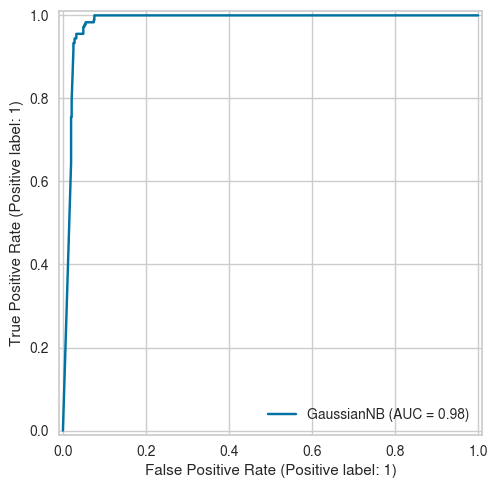


Logistic Regression Results:
Time: 29 ms
F1 Score: 0.98
MCC Score: 0.95
Precision: 0.98




Naive Bayes Results:
Time: 8 ms
F1 Score: 0.97
MCC Score: 0.89
Precision: 0.97



In [75]:
result_lr_baseline_important_features, result_nb_baseline_important_features = evaluate(X_train, X_test, y_train, y_test)
trained_logreg_important_features, trained_nb_important_feature = result_lr_baseline_important_features["model"], result_nb_baseline_important_features["model"]

In [76]:
# Dopo che abbiamo appurato che produce buoni risultati possiamo aggiornare il dataset contenente solo le feature più importanti
most_important_features = most_important_features[most_important_features_columns]
most_important_features_columns = most_important_features.columns

## Sporcare il dataset

### Introduzione

In questa fase vogliamo dunque sporcare il dataset. Con il dataset sporcato andremo poi ad utilizzare i baseline model per valutare di quanto variano le predizioni dai risultati precedentemente ottenuti con il dataset integro. Per fare ciò si decide di fare test in modi separati: 
- per il modello di Logistic Regression: potremmo osservare e valutare l'influenza sulle performance del modello:
    - sia come si comporta il modello solo quando le feature meno importanti sono sporcate (mantenendo tutte le feature del modello e sporcando quelle meno importanti)
    - sia come si comporta il modello quando le feature più importanti sono sporcate (mantenendo però tutte le feature originali del modello e sporcando quelle importanti)
    - sia come si comporta il modello quanto TUTTE le feature sono sporcate (mantenendo quindi tutte le feature del modello)
    - sia come si comporta il modello mantenendo nel set solo ed esclusivamente le feature più importanti e sporcandole 
- per il modello di Naive Bayes: si decide di usare direttamente il data-set con solo le feature più importanti, senza considereare altri dataset con tute le feature ma sporcati in modi diversi, in quanto abbiamo già provato che con troppe feature il modello non funziona bene, rasenta il classificatore casuale. In questo modo almeno riuscremo comunque a verificare la persistenza del modello allo sporcare dei dati

Per ognuna di questi step ci salveremo i risultati delle elaborazioni in un array chiamato `post_elaboration_result_xxxx` sul quale andremmo poi a trarre le nostre conclusioni. 

Inoltre ognuno questo gruppo di step verrà eseguito più volte modificando il valore dela variabile sottostante `actual_percentage` per vedere come variano le performance dei modelli che andiamo ad addestrare di volta in volta aumentando progressivamente il numero di dati sporcati.

In [147]:
# vaiabile di percentuale sporrcaggio dati
actual_pecentage = 0.70

#nota: si sceglie di mostrare i risultati nella relazione per: 40% - 55% - 70% - 85%

#### Funzione per visualizzare numero di istanze differenti tra dataset pulito e dataset sporco

Si scrive poi questa funzione per visualizzare in maniera più rapida ed intuitiva quanti dati sono cambiati in seguito alla nostra operazione di sporcare i dati:

In [148]:
# Metodo per visualizzare visivamente quanti dati sono stati sporcati
def visualize_difference(dataset1, dataset2, percent_count=0.2):
    # Calcola le differenze tra i due dataset
    differenze = dataset1 != dataset2

    # Crea il grafico
    fig, ax = plt.subplots()

    # Calcola il numero di istanze in cui le feature sono uguali
    uguali = np.sum(~differenze, axis=0)

    # Calcola il numero di istanze in cui le feature sono diverse
    diverse = np.sum(differenze, axis=0)
    
    # Trova le colonne con un numero di differenze inferiore al percent_count% delle istanze totali (se non lo specifico allora sarà 20%)
    num_instances = dataset1.shape[0] #Calcola il numero totale di istanze
    num_diff = np.sum(differenze, axis=0) #Calcola il numero di differenze per ogni feature
    low_diff_columns = np.where(num_diff < percent_count * num_instances)[0]

    # Imposta la larghezza delle barre
    bar_width = 0.4

    # Imposta l'indice delle barre
    bar_index = np.arange(dataset1.shape[1])

    # Barre per le feature che sono diverse
    ax.bar(bar_index, diverse, bar_width, color='red', label='Diverse')

    # Barre per le feature che sono uguali
    ax.bar(bar_index, uguali, bar_width, bottom=diverse, color='blue', label='Uguali')

    # Imposta il titolo e le etichette degli assi
    ax.set_title('Numero di istanze differenti tra il prima e dopo aver sporcato i dati:')
    ax.set_ylabel('Numero di istanze')
    if(len(dataset1.columns)<=40):#se ci sono meno di 40 features stampa anche il nome
        ax.set_xticks(np.arange(len(diverse)))
        ax.set_xticklabels(dataset1.columns, rotation=90)
    ax.legend(loc='upper right', bbox_to_anchor=(1.17, 1))

    # Mostra il grafico
    plt.show()

    return low_diff_columns

#### Funzione per valutare le differenze di perfrormance tra baseline e varie istanze di modelli con dati sporchi

In [400]:
def evaluate_overall_performance(post_elaboration_result_xxxx):

    # Liste di elementi con gli attributi di baseline
    times_baseline = [ result_lr_baseline_full['time'] , 
                    result_lr_baseline_full['time'], 
                    result_lr_baseline_full['time'], 
                    result_lr_baseline_important_features['time'], 
                    result_nb_baseline_important_features['time'] ]

    f1scores_baseline = [ result_lr_baseline_full['f1score'] , 
                        result_lr_baseline_full['f1score'], 
                        result_lr_baseline_full['f1score'], 
                        result_lr_baseline_important_features['f1score'], 
                        result_nb_baseline_important_features['f1score'] ]

    mccscores_baseline = [ result_lr_baseline_full['mccscore'] , 
                        result_lr_baseline_full['mccscore'], 
                        result_lr_baseline_full['mccscore'], 
                        result_lr_baseline_important_features['mccscore'], 
                        result_nb_baseline_important_features['mccscore'] ]

    # Estrazione valori risultati dalla lista precedentemente salvata
    times = []
    f1scores = []
    mccscores = []

    for entry in post_elaboration_result_xxxx:
        times.append(entry['time'])
        f1scores.append(entry['f1score'])
        mccscores.append(entry['mccscore'])

    # Plotto i 3 risultati
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1)


    # Plot tempo di elaborazione
    ax0.plot(times, label='Training time con dati sporchi')
    ax0.bar(range(len(times)), times, alpha=0.5)  
    for i, value in enumerate(times):
        ax0.text(i, value, str(value), ha='center', va='bottom')
    ax0.set(ylabel='Training Time (ms)')


    # Plot f1-score
    ax1.plot(f1scores, label='F1 Score', c='orange')
    for i, value in enumerate(f1scores):
        ax1.text(i, value, str(round(value, 3)), ha='center', va='top', c='orange')
    ax1.bar(range(len(f1scores)), f1scores, alpha=0.5, color='yellow') 

    ax1.plot(f1scores_baseline, label='Baseline F1 Score', c='r')#baseline
    for i, value in enumerate(f1scores_baseline):
        ax1.text(i, value, str(round(value, 3)), ha='center', va='bottom', c='r')
    ax1.bar(range(len(f1scores_baseline)), f1scores_baseline, alpha=0.1, color='r') 

    ax1.set(ylabel='F1-Score')


    # Plot mcc-score
    ax2.plot(mccscores, label='MCC Score', c='darkgreen')
    for i, value in enumerate(mccscores):
        ax2.text(i, value, str(round(value, 3)), ha='center', va='top', c='darkgreen')
    ax2.bar(range(len(mccscores)), mccscores, alpha=0.5, color='g') 

    ax2.plot(mccscores_baseline, label='Baseline MCC Score', c='r')#baseline
    for i, value in enumerate(mccscores_baseline):
        ax2.text(i, value, str(round(value, 3)), ha='center', va='bottom', c='r')
    ax2.bar(range(len(mccscores_baseline)), mccscores_baseline, alpha=0.1, color='r') 

    ax2.set(ylabel='MCC-Score')


    ax0.legend(loc='upper right', bbox_to_anchor=(1.30, 1))
    ax1.legend(loc='upper right', bbox_to_anchor=(1.30, 1))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.33, 1))

    plt.subplots_adjust(hspace=0.9)
    plt.show()

### Sostituzione di valori con valori casuali

In questa sezione esploriamo questo scenario, ossia inseriremo nel dataset dati casuali. 

Quello che ci aspettiamo è di vedere è: 
- vedere risultati dove avendo molte feature sporche il target viene classificato erroneamente rispetto al baseline model. Questo deriva molto semplicemente dal fatto che inseriamo sempre valori casuali per il `actual_pecentage` dei dati 
- i risultati otenuti possono variare da run a run anche mettendo la stessa percentuale in quanto non possiamo impostare al metodo implementato di seguito per l'inserimento di valori casuali di inserire sempre gli stessi valori nelle stesse celle

In [401]:
# importing the random module
import random

In [402]:
# Metodo per l'inserimento di valori nulli solo in certe colonnne:
def insert_randoms(X_train, features_names, random_percentage):
    # Copia del DataFrame per non modificare l'originale
    X_train_copy = X_train.copy()
    
    # Inserimento di valori nulli nelle colonne specificate
    for feature in features_names:
        if feature in X_train_copy.columns:
            # Calcola il numero di valori nulli da inserire
            num_nulls = int(X_train_copy[feature].size * random_percentage)
            # Seleziona casualmente gli indici delle celle da impostare a null
            null_indices = np.random.choice(X_train_copy.index, size=num_nulls, replace=False)
            # Imposta i valori a caso tra 0 ed 1
            X_train_copy.loc[null_indices, feature] = random.randint(0,1)

    colonne_min_diff = visualize_difference(X_train, X_train_copy)
    
    return (X_train_copy, colonne_min_diff)

In [403]:
# Variabile per salvare i risultati post valutazione con modello
post_elaboration_result_RandomData = []

#### 1. Logistic Regression - sporcare i dati meno significativi

Per prima cosa generiamo nuove variabili di train e test che partono dal dataset contenente tutte le feature

In [404]:
X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

Poi, al solito, creaiamo una copia del train set da sporcare:

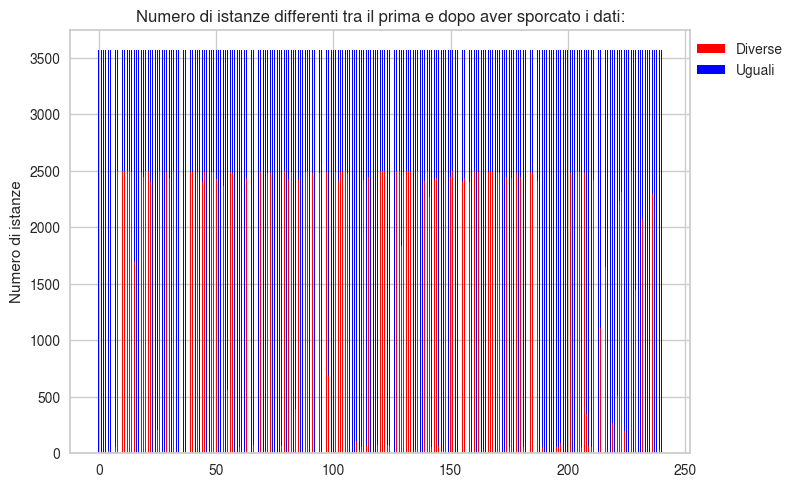

In [405]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
(inconsistent_uni_feature, min_diff_columns) = insert_randoms(X_train=inconsistent_uni_feature, features_names=less_important_features, random_percentage=actual_pecentage)

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


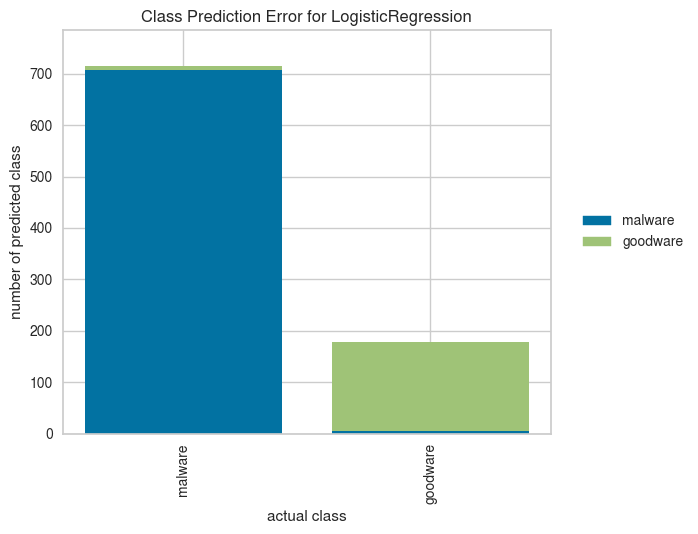

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


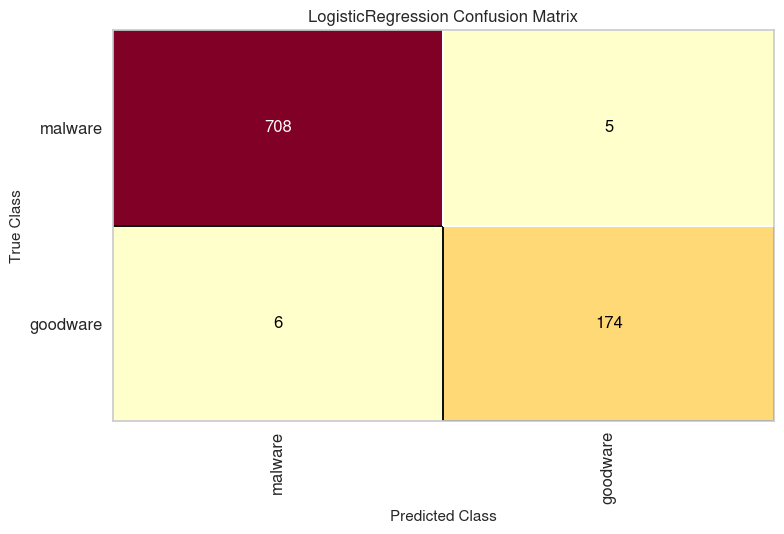

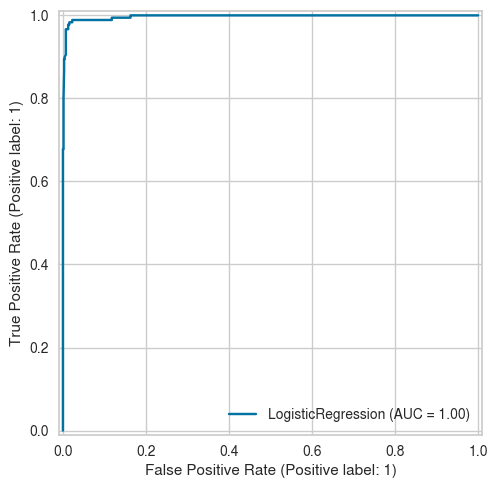


Logistic Regression Results:
Time: 408 ms
F1 Score: 0.99
MCC Score: 0.96
Precision: 0.99



In [406]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_RandomData.append(logreg)

Differentemente dall'esempio precedente mantenendo invece intatte le feature più importanti, come da aspettarsi, le performance calano significativamente ma possiamo comunque dire di avere dei risultati "discreti". 

Il vero downgrade di questa classificazione è che comunque molte istanze di malware vengono classificate come goodware e, come abbiamo osservato prima, questo è un caso molto più grave che etichettare le istanze di goodware come malware.

#### 2. Logistic Regression - sporcare le feature più significative (mantenendo altre feature)

Per prima cosa generiamo nuove variabili di train e test che partono dal dataset contenente tutte le feature

In [407]:
X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

Inseriamo questa volta dei valori nulli solo all'interno delle colonne più significative per vedere la risposta del modello.

Per fare ciò partiamo a generare una copia del dataset nelle quali colonne andremo ad inserire i valori nulli, ma solo se queste feature sono comprese nella variabile `most_important_features_columns`

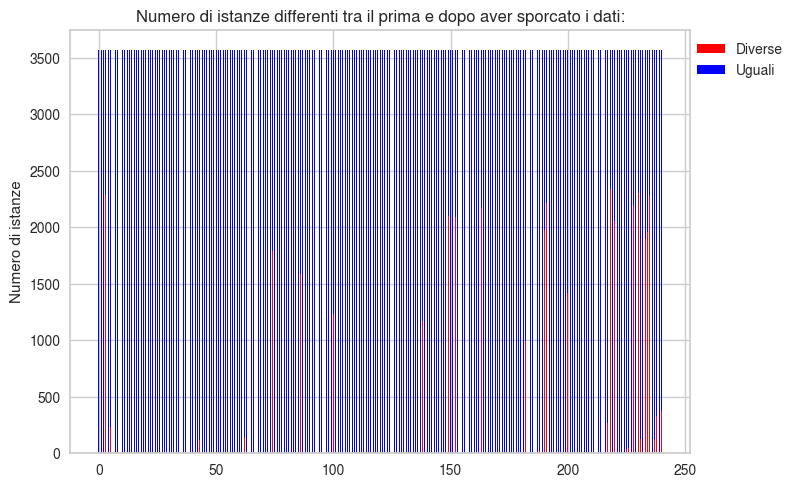

In [408]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
(inconsistent_uni_feature, min_diff_columns) = insert_randoms(X_train=inconsistent_uni_feature, features_names=most_important_features_columns, random_percentage=actual_pecentage)

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


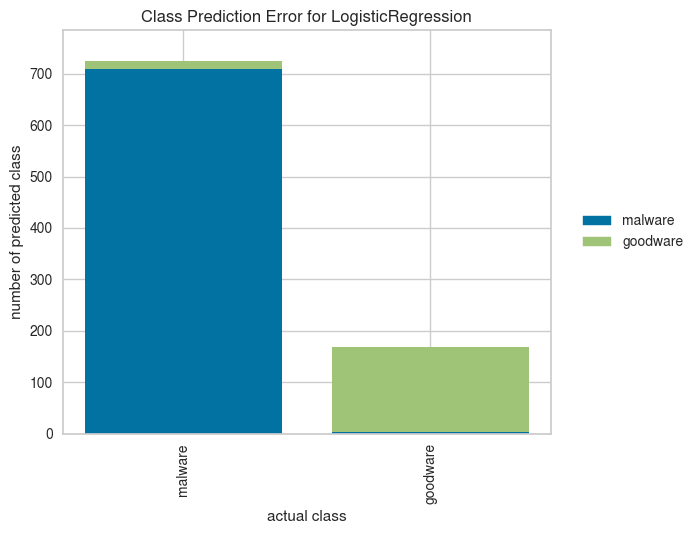

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


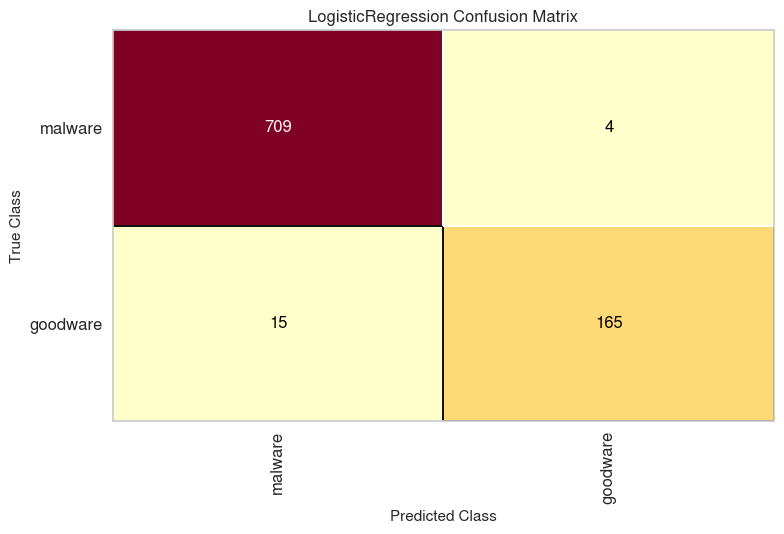

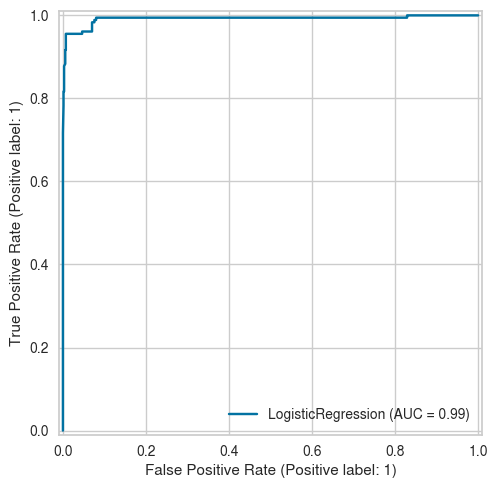


Logistic Regression Results:
Time: 115 ms
F1 Score: 0.98
MCC Score: 0.93
Precision: 0.98



In [409]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_RandomData.append(logreg)

Questo risultato è simile (anche se chiaramente peggiore) al risutltato ottenuto con l'eliminazione di valori random. (Ossia il punto 3 del capitolo precedente), quindi valgono [più o meno] le stesse considerazione che abbiamo fatto per quel capitolo.

#### 3. Logistic Regression - sporcare tutte le features

Per prima cosa generiamo nuove variabili di train e test che partono dal dataset contenente tutte le feature

In [410]:
X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

Inseriamo dunque dei valori nulli all'interno del dataset. Per fare ciò partiamo a generare una copia del dataset nelle quali colonne andremo ad inserire i valori nulli, questo per evitare di sporcare permanentemente i dati originali

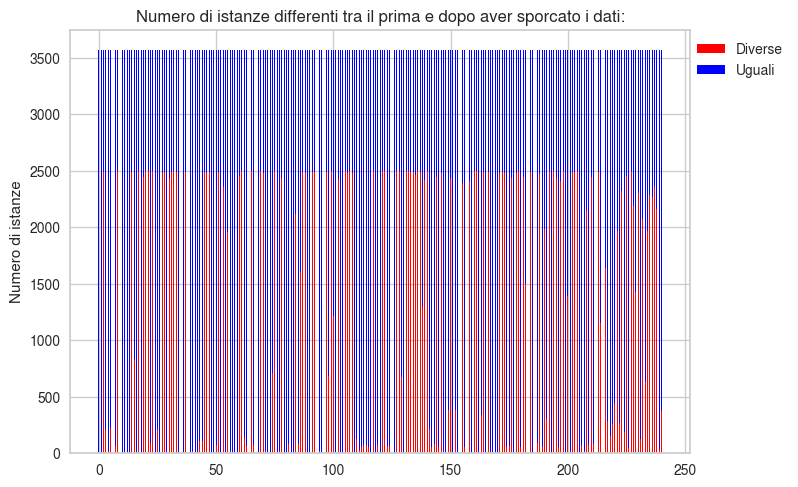

In [411]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
(inconsistent_uni_feature, min_diff_columns) = insert_randoms(X_train=inconsistent_uni_feature, features_names=uni_feature.columns, random_percentage=actual_pecentage)

Tutte le colonne contengono ora per il `actual_percentage`% valori casuali.


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


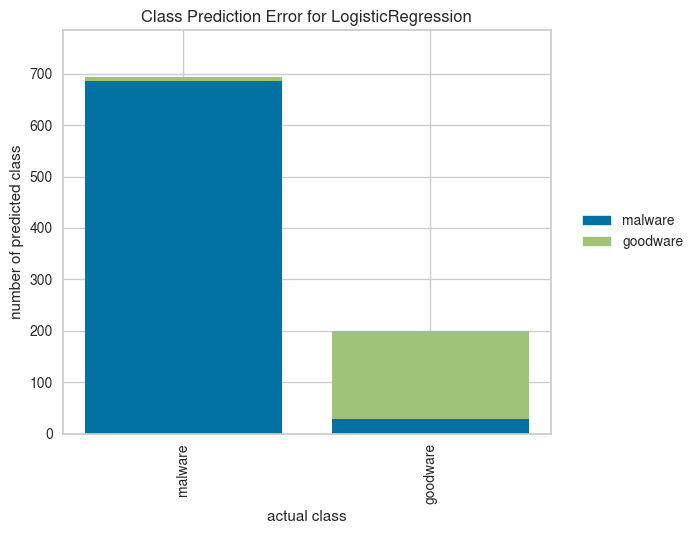

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


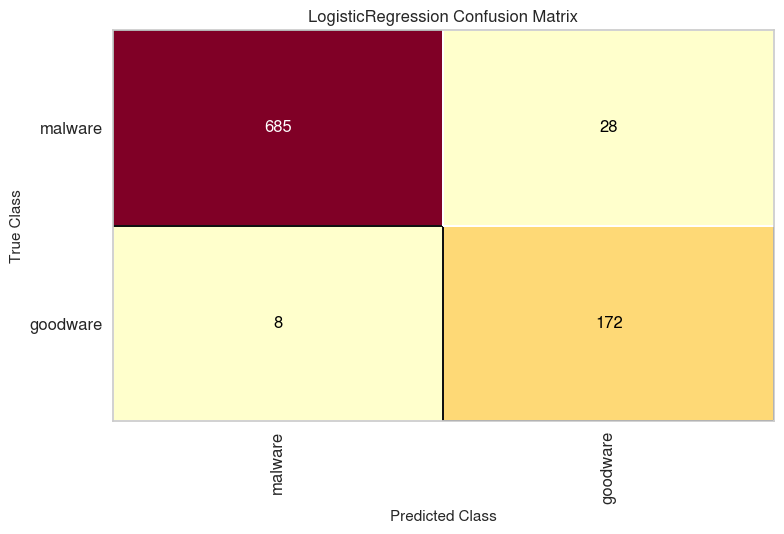

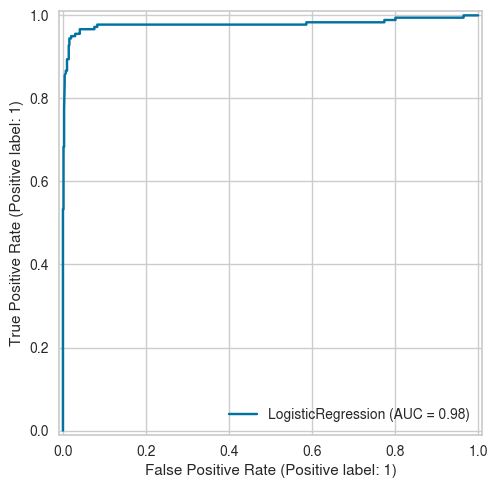


Logistic Regression Results:
Time: 403 ms
F1 Score: 0.96
MCC Score: 0.88
Precision: 0.96



In [412]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_RandomData.append(logreg)

#### 4. Logistic Regression - sporcare le feature più significative (senza altre feature)

Per prima cosa generiamo nuove variabili di train e test che partono dal dataset contenente solo le feature più importanti

In [413]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

In questo caso partimo direttamente generare una copia del dataset che contiene solo le feature più importanti `most_important_features` e poi andremo a sporcarle tutte

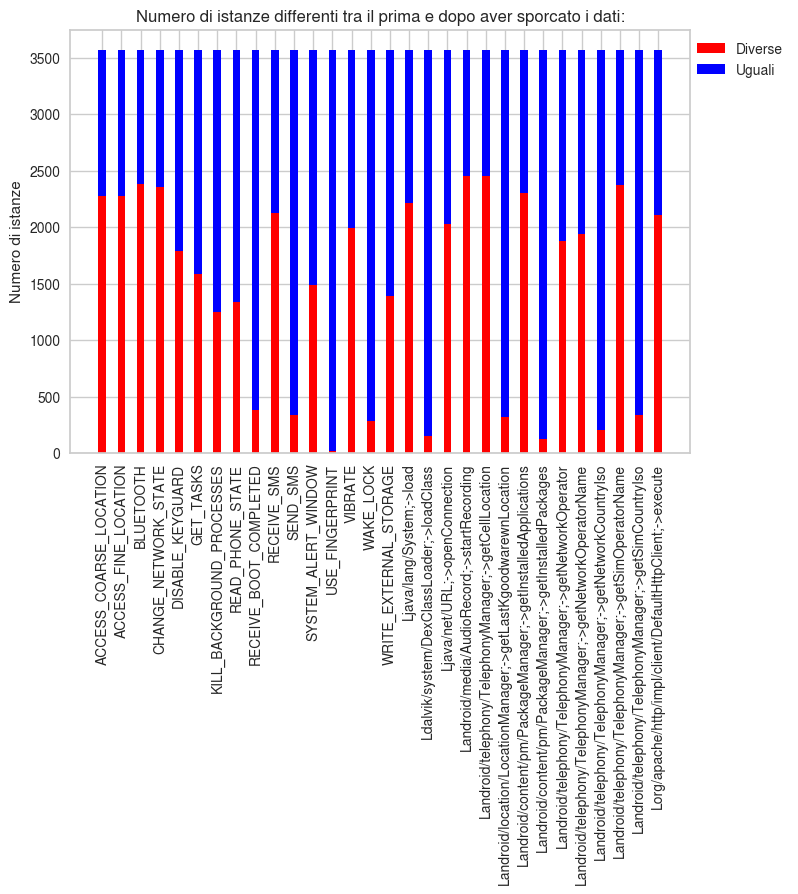

In [414]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
(inconsistent_uni_feature, min_diff_columns) = insert_randoms(X_train=inconsistent_uni_feature, features_names=most_important_features_columns, random_percentage=actual_pecentage)

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


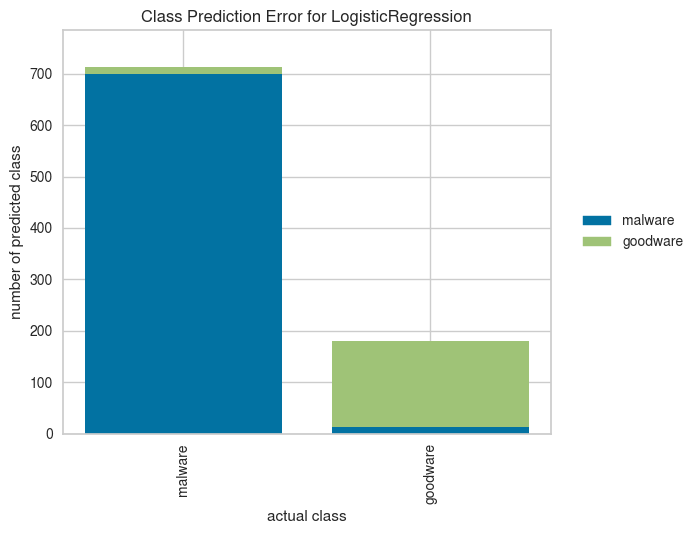

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


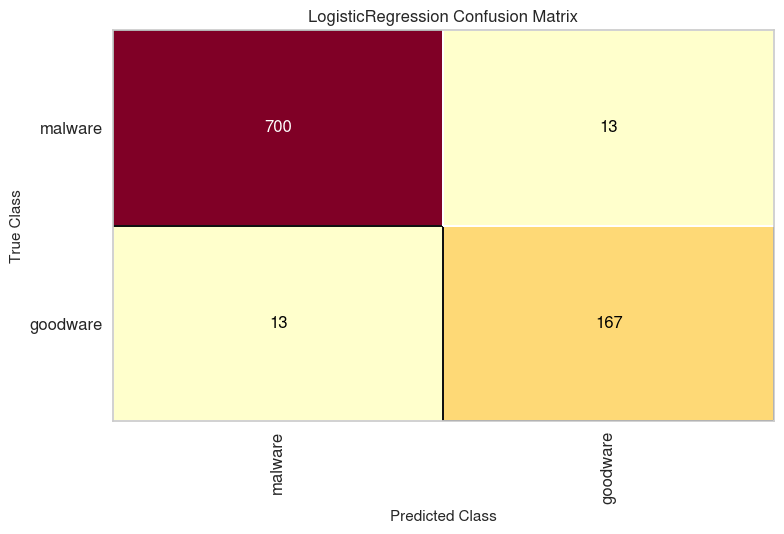

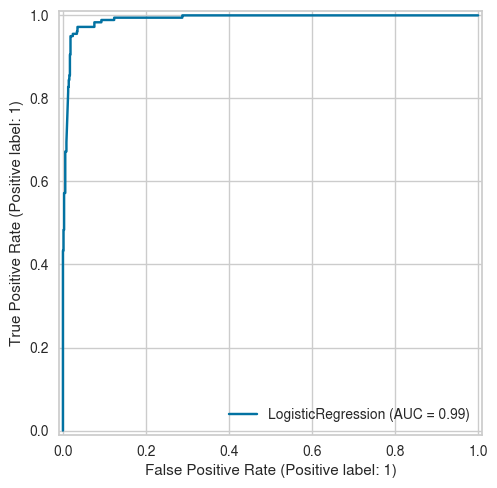


Logistic Regression Results:
Time: 43 ms
F1 Score: 0.97
MCC Score: 0.91
Precision: 0.97



In [415]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_RandomData.append(logreg)

#### 5. Naive Bayes - sporcare le feature più significative  (senza altre feature)

Siccome abbiamo già creato per il modello precedete una copia del dataset che contiene solo le feature più importanti `most_important_features` e queste sono anche già state sporcate e divise in train e test set possiamo direttamente procedere con la valutazione dei dati per vedere come si comporta il modello:


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


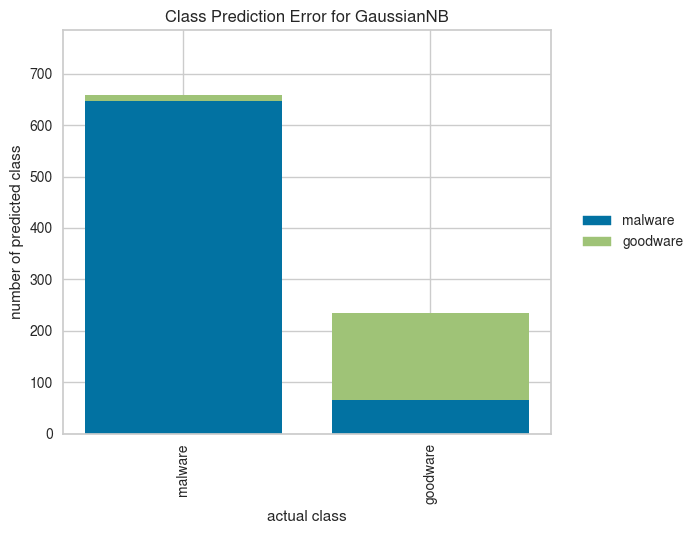

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


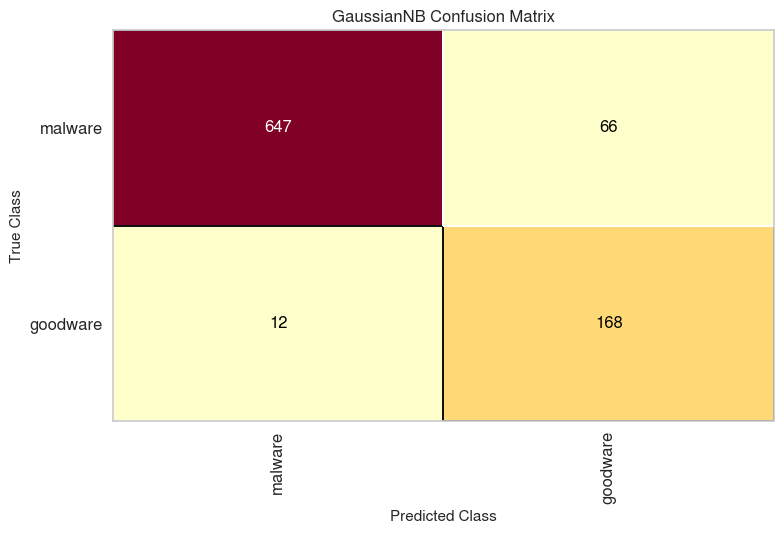

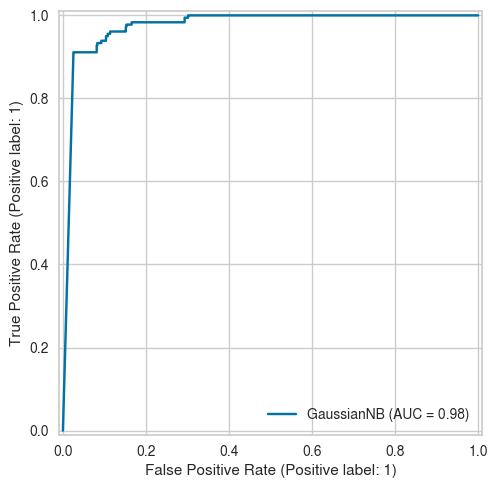


Naive Bayes Results:
Time: 11 ms
F1 Score: 0.91
MCC Score: 0.77
Precision: 0.91



In [416]:
# valutazione tramire Naive Bayes delle nuove performance
nb = evaluate_with_Naive_Bayes(train_df=inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["naive_bayes"]
print_results_nb(nb)

# salvo il risultato nella lista
post_elaboration_result_RandomData.append(nb)

#### 6. Brevi conclusioni

TypeError: 'Figure' object is not callable

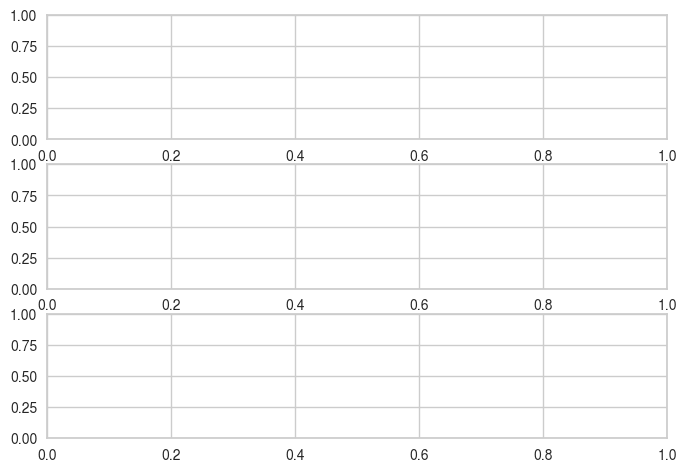

In [417]:
evaluate_overall_performance(post_elaboration_result_RandomData)

##### Considerazioni sul decadimento delle performance di tra baseline e modelli con dati sporchi:

Notiamo che nonostante sappiamo sia sempre la stessa percentuale per ogni feature di dati che vengono sostituiti, non è detto che su `actual_percentage`% di dati che vengono sporcati su ogni feature allora ogni valore che viene inserito allora sia sbagliato. Anzi siccome tutte le feature sono binarie ogni volta che si fa' una sostituzione con un valore casuale si ha il 50% di possibilità di inserire il valore corretto. Il che vuol dire che anche sporcando per una soglia del 70% possiamo comunque ad arrivare ad avere un dataset abbastanza pulito per puro caso; questo risultato è particolarmente visibile ai punti 4 e 5.

È facile vedere che (con qualsiasi percentuale di inserimento dati casuali) le performance di classificazione del modello rimangono sempre molto alte, la mia ipotesi su questo comportamente è che avendo delle feature che sono molto meno sporche delle altre semplicemente entrambi i classificatori vanno a dare peso maggiore a queste feature meno sporche per fare la classificazione (e avrebbe senso considerando che sia NaiveBayes che regressione logistica danno un certo peso a certe feature piuttosto che altre per fare la classificazione, e avendo che le feature selezionate per i punti 4 e 5 quelle più significative del dataset sporcandole non possono fare altro che perdere valore informativo quindi venire considerate dai classificatori come meno importanti), in questo modo si spiegherebbe come riescono ad ottenere comunque ottimi risultati di classificazione.

Un buon modo per testare questa ipotesi è di riaddestrare i modelli prendendo però solo le colonne che sono state sporcate di meno (quindi che hanno un numero di differenze minore del 20%) e vedere quali sono le nuove performance; potremo così compararle a quelle ottenute nei punti 4 e 5. Se queste combaciano o sono molto simili allora la mia teoria è confermata. 

Nota: avrebbe senso aspettarsi che le performance di questo esperimento siano entrambe:
- o leggermente più alte dei modelli precedenti in quanto i nuovi modelli non sono influenzati dalle colonne contenenti più dati sporchi. Quindi ci aspettiamo performance simili ma leggermente più alte.
- o leggermente più basse rispetto ai modelli precedenti in quanto le colonne selezinate per il nostro esperimento (ossia le feature che contengono un numero di differenze minore del 20% dopo essere state sporcate) tra tutte le colonne disponibili in `most_important_features` possono comunque venire selezionate quelle con il valore di significatività più basso (o che magari avrebbero bisogno di altre colonne per raggiungere una significatività più alta)
Entrambi i ragionamenti sono corretti e ri-runnando il progetto anche mantenendo uguale la variabile `actual_percentage` (che gestisce il numero)

Dunque per testare questa ipostesi mi sono salvato nella variabile `min_diff_columns` gli indici delle feature che vengono sporcate per il 20% o meno delle istanze totali nei passaggi 4 e 5 e proviamo ora a comparare i risultati:

In [ ]:
for item in most_important_features_columns[min_diff_columns]:
    print(item)

ACCESS_COARSE_LOCATION
ACCESS_FINE_LOCATION
BLUETOOTH
CHANGE_NETWORK_STATE
DISABLE_KEYGUARD
RECEIVE_BOOT_COMPLETED
RECEIVE_SMS
USE_FINGERPRINT
Ljava/lang/System;->load
Ljava/net/URL;->openConnection
Landroid/location/LocationManager;->getLastKgoodwarewnLocation
Landroid/content/pm/PackageManager;->getInstalledApplications
Landroid/telephony/TelephonyManager;->getNetworkCountryIso
Landroid/telephony/TelephonyManager;->getSimOperatorName


In [ ]:
# creiamo le variabili di trai e test dummy per questo esperimento
X_tain_dummy = X_train.iloc [:, min_diff_columns]
X_test_dummy = X_test.iloc [:, min_diff_columns]


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


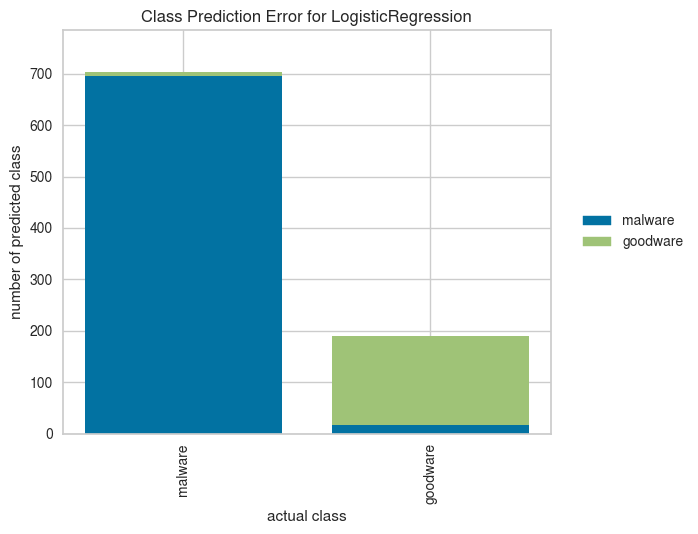

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


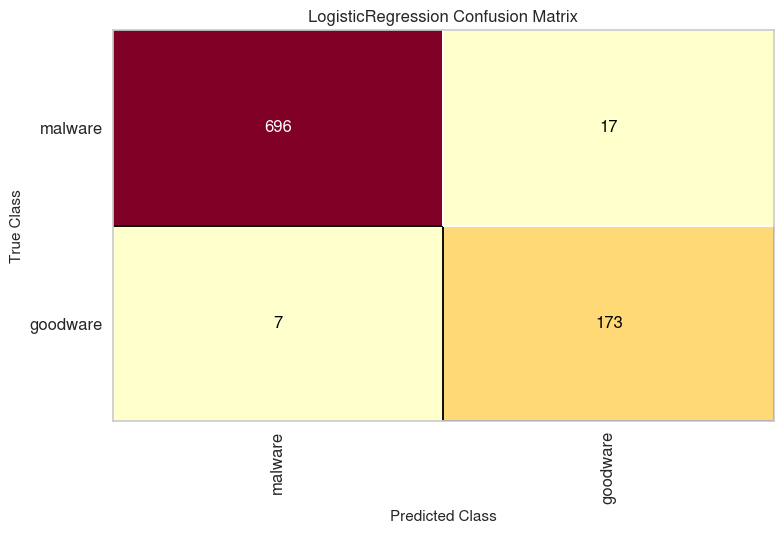

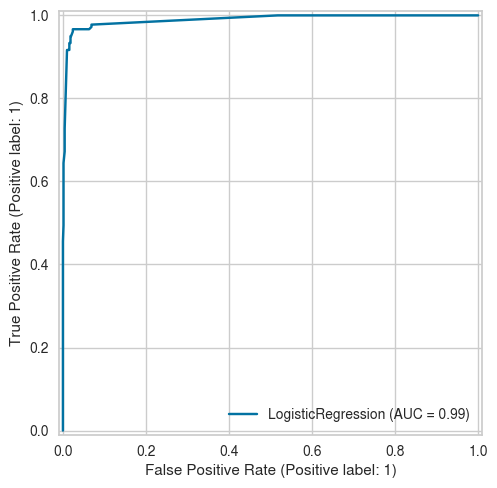


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


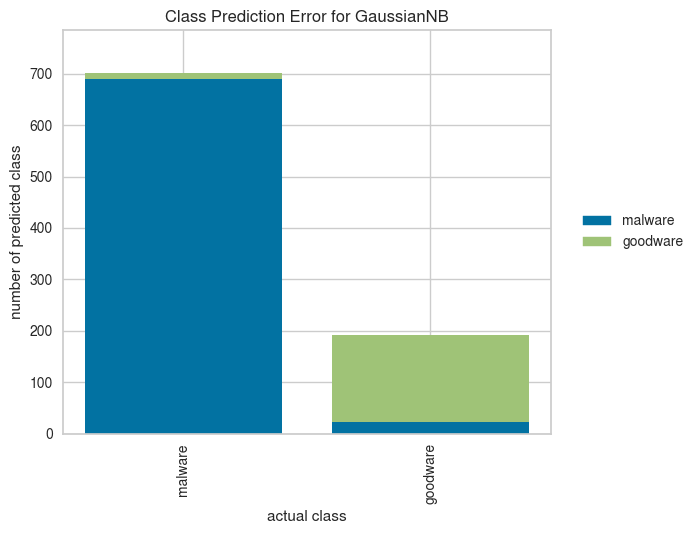

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


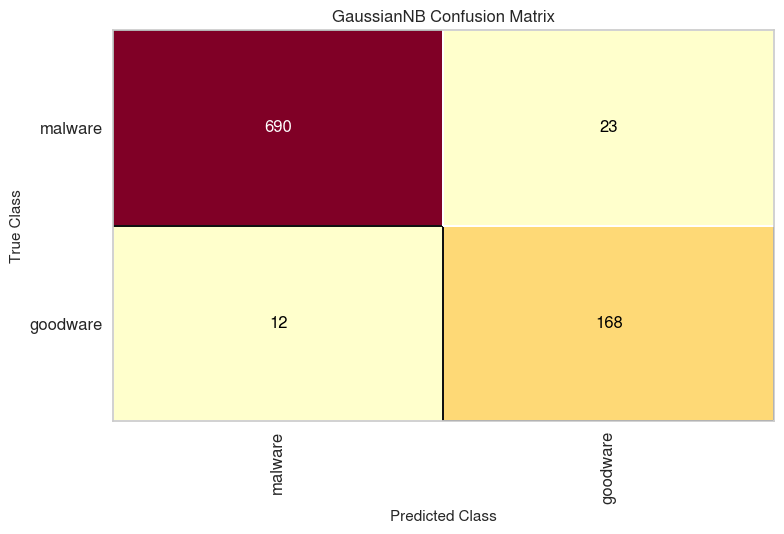

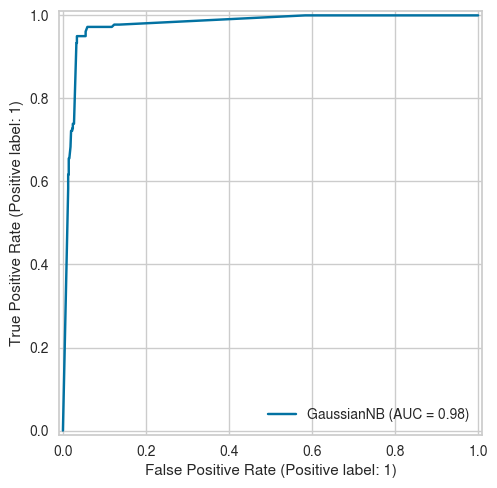


Logistic Regression Results:
Time: 21 ms
F1 Score: 0.97
MCC Score: 0.92
Precision: 0.97




Naive Bayes Results:
Time: 7 ms
F1 Score: 0.96
MCC Score: 0.88
Precision: 0.96



In [ ]:
(result_lr, result_nb) = evaluate(X_train=X_tain_dummy, X_test=X_test_dummy, y_train=y_train, y_test=y_test)

Visualizzazione grafica del confronto tra i risultati dei punti 4 & 5 e dei risultati appena ottenuti con i 2 nuovi modelli:

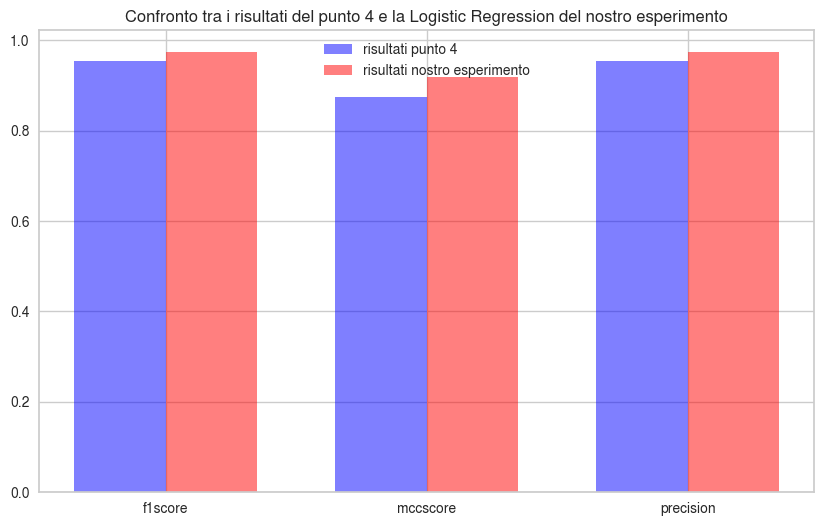

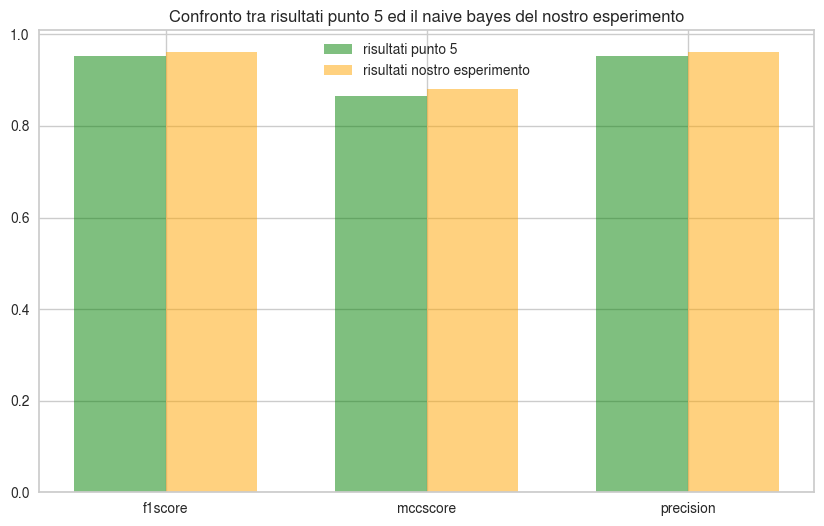

In [ ]:
# Estraggo gli ultimi due oggetti dall'array
result_punto_4 = post_elaboration_result_RandomData[-2]
result_punto_5 = post_elaboration_result_RandomData[-1]

attributi = ['f1score', 'mccscore', 'precision'] #etichette degli attributi che vogliamo paragonare

# estraggo i valori degli attributi per il primo confronto
valori_penultimo_logreg = [result_punto_4[attributo] for attributo in attributi] #valosri attributi NB al punto 4
valori_logreg = [result_lr[attributo] for attributo in attributi] #valori attributi LR nostro espetimento

# estraggo i valori degli attributi per il secondo confronto
valori_ultimo_nb = [result_punto_5[attributo] for attributo in attributi] #valosri attributi NB al punto 5
valori_nb = [result_nb[attributo] for attributo in attributi] #valori attributi NB nostro espetimento

larghezza_barre = 0.35
posizioni = np.arange(len(attributi))

# Creazione del primo plot
plt.figure(figsize=(10, 6))
plt.bar(posizioni - larghezza_barre/2, valori_penultimo_logreg, larghezza_barre, color='blue', alpha=0.5, label='risultati punto 4')
plt.bar(posizioni + larghezza_barre/2, valori_logreg, larghezza_barre, color='red', alpha=0.5, label='risultati nostro esperimento')
plt.title('Confronto tra i risultati del punto 4 e la Logistic Regression del nostro esperimento')
plt.xticks(posizioni, attributi)
plt.legend()
plt.show()

# Creazione del secondo plot
plt.figure(figsize=(10, 6))
plt.bar(posizioni - larghezza_barre/2, valori_ultimo_nb, larghezza_barre, color='green', alpha=0.5, label='risultati punto 5')
plt.bar(posizioni + larghezza_barre/2, valori_nb, larghezza_barre, color='orange', alpha=0.5, label='risultati nostro esperimento')
plt.title('Confronto tra risultati punto 5 ed il naive bayes del nostro esperimento')
plt.xticks(posizioni, attributi)
plt.legend()
plt.show()


L'esperimento è riuscito! Siamo riusciti a confermare con prove concrete la nostra ipotesi: siccome i modelli trainati solo con i dati sporcati solo al di sotto del 20% riportano performance pressapoco identiche a quelli trainati al punto 4 e 5 trainati con il dataset di `most_important_features` (in seguito ad averlo sporcato con valori casuali) possiamo affermare con certezza che i nostri modelli riescono comunque ad estrarre buoni risultati di predizione perchè apprendono solo sulle feature che casualmente vengono sporcate di meno

##### Considerazioni del decadimento delle performance passo-passo:

roba

### Inserimento di valori nulli

Come primo tentativo di sporcare i dati vogliamo inserire valori nulli all'interno dei nostri set. Siccome poi, una volta eseguita questa operazione, non possiamo rieseguire la classificazione in presenza di valori null nel nostro dataset dedicidiamo di cancellare alcune celle a caso dalle nostro istanze ma poi le ri-filleremo con la moda della relativa colonna.

Nota: generalmente un buon metodo per il riempimento di valori vuoti è il metodo `KNNImputer` (utilizzato per imputare, ovvero stimare, i valori mancanti nei dati utilizzando un algoritmo basato sul vicinato più prossimo (K-nearest neighbor)). Tuttavia, quando tutte le tue feature sono binarie (0/1) come nel nostro caso, la nozione di "distanza" può essere problematica, poiché non è immediatamente chiaro come definire la similarità tra osservazioni basata solo su valori binari. Inoltre, l'imputazione tramite KNN potrebbe non produrre risultati molto significativi quando si trattano feature binarie.

Invece, una strategia più semplice e potenzialmente più appropriata potrebbe essere l'imputazione utilizzando la moda (il valore più frequente) per ciascuna feature.

In [ ]:
# Visualizzazione di valori nulli all'interno di una colonna
import missingno as msno

# Autocompletamento di dati mancanti
from sklearn.impute import SimpleImputer

In [ ]:
# Metodo per l'inserimento di valori nulli solo in certe colonnne:
def insert_nulls(X_train, features_names, null_percentage):
    # Copia del DataFrame per non modificare l'originale
    X_train_copy = X_train.copy()
    
    # Inserimento di valori nulli nelle colonne specificate
    for feature in features_names:
        if feature in X_train_copy.columns:
            # Calcola il numero di valori nulli da inserire
            num_nulls = int(X_train_copy[feature].size * null_percentage)
            # Seleziona casualmente gli indici delle celle da impostare a null
            null_indices = np.random.choice(X_train_copy.index, size=num_nulls, replace=False)
            # Imposta i valori a null
            X_train_copy.loc[null_indices, feature] = np.nan
    
    return X_train_copy

In [ ]:
# Variabile per salvare i risultati post valutazione con modello
post_elaboration_result_NullData = []

#### 1. Logistic Regression - sporcare tutte le features

Per prima cosa generiamo nuove variabili di train e test che partono dal dataset contenente tutte le feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

Inseriamo dunque dei valori nulli all'interno del dataset di train. Per fare ciò partiamo a generare una copia del dataset nelle quali colonne andremo ad inserire i valori nulli, questo per evitare di sporcare permanentemente i dati originali

<Axes: >

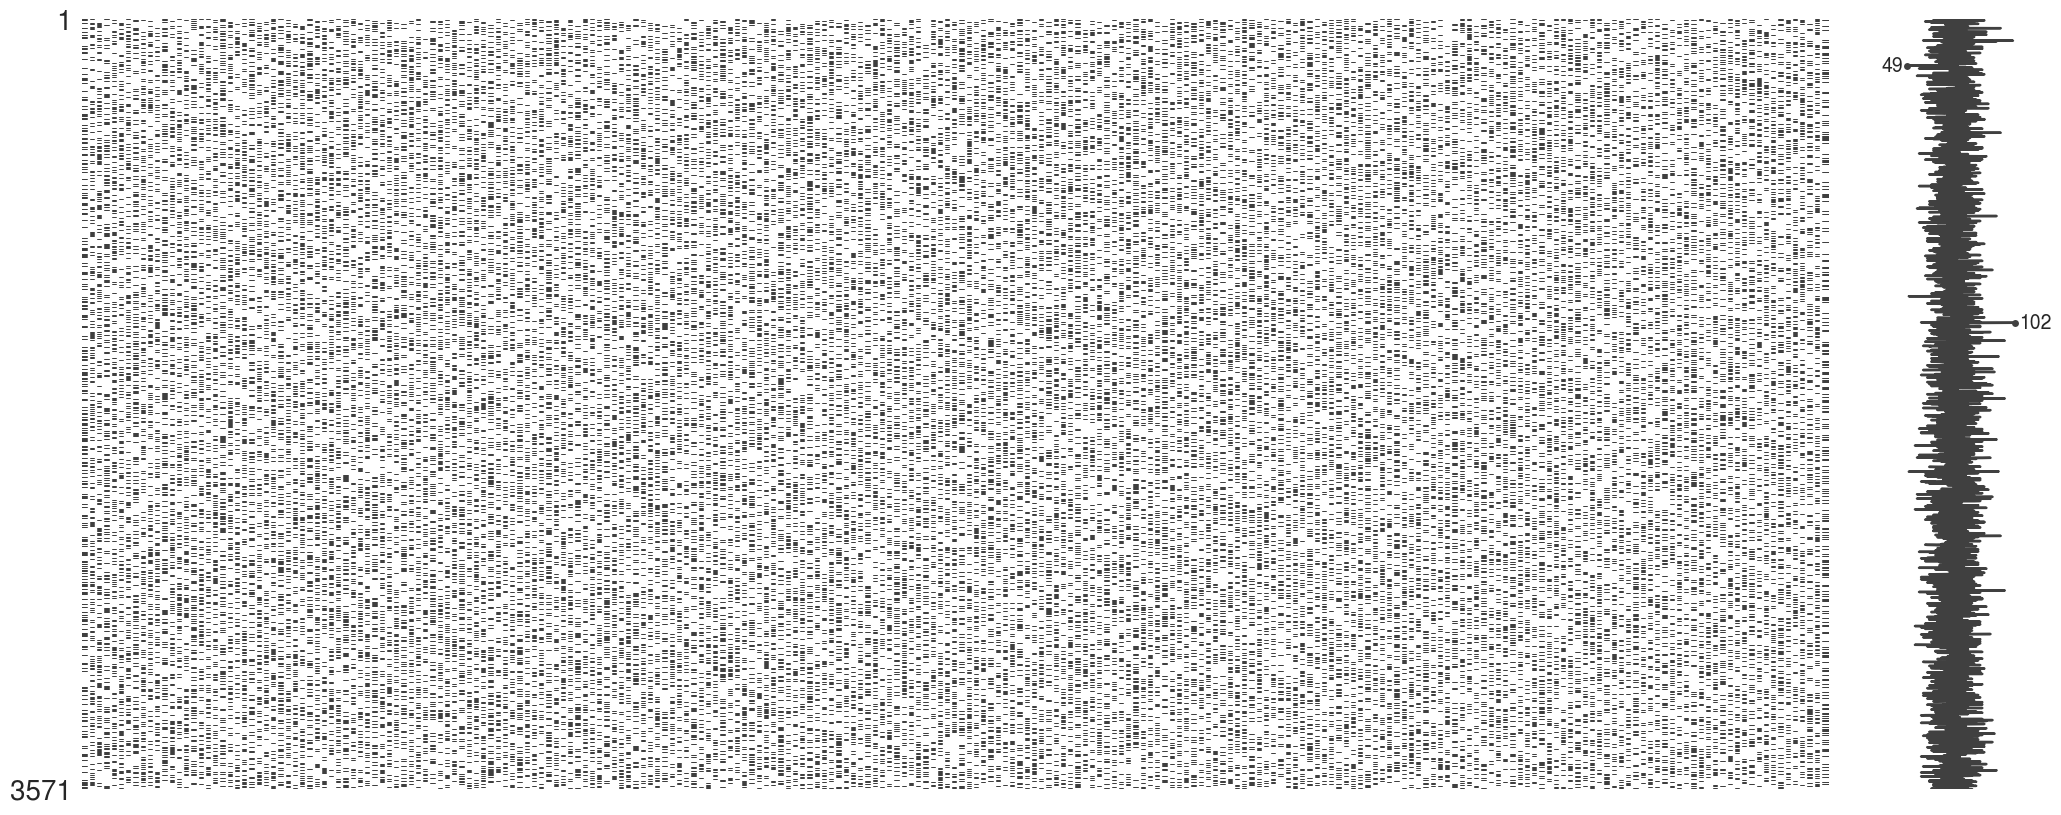

In [ ]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
inconsistent_uni_feature = insert_nulls(X_train=inconsistent_uni_feature, features_names=inconsistent_uni_feature.columns, null_percentage=actual_pecentage)

# visualizzazione valori nulli
msno.matrix(inconsistent_uni_feature)

Nella visuala appena mostrata ogni colonna del dataset è rappresentata da una colonna di dati dove:
- c'è uno spazio vuoto se il dato è mancante
- c'è una cella nera se il dato esiste

Nella visual appena mostrata riusciamo a vedere quanto abbiamo sporcato il dataset. Tutte le colonne contengono ora per il `actual_pecentage`% valori mancanti.

Ora procediamo con il refill dei valori nulli con la moda

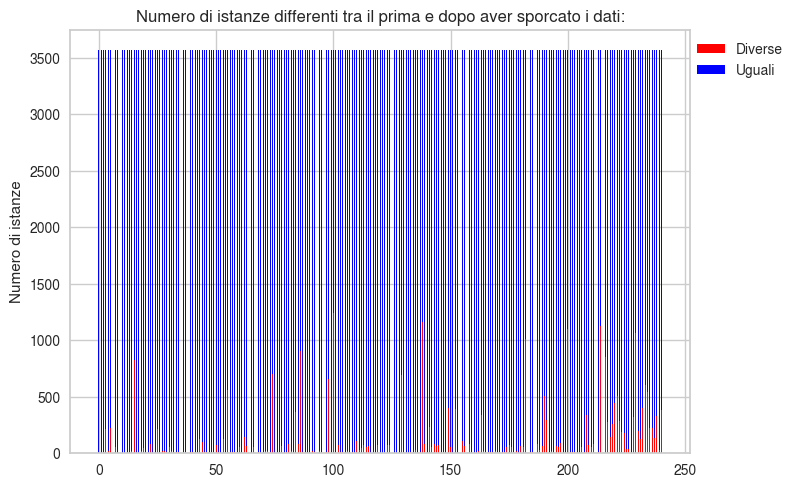

in totoale abbiamo che inserendo 70.0% di dati nulli
si ha che su 241 features abbiamo che solo 0 hanno più del 35.0% di dati sporchi


In [ ]:
# Crea un imputer che sostituisce i valori mancanti con la moda
imputer = SimpleImputer(strategy='most_frequent', fill_value=float)

# Addestra l'imputer sui dati di addestramento
imputer.fit(inconsistent_uni_feature)

# Riempie i valori vuoti
imputed_inconsistent_uni_feature = pd.DataFrame(imputer.transform(inconsistent_uni_feature), columns=inconsistent_uni_feature.columns)
imputed_inconsistent_uni_feature.index = X_train.index

# Visualizziamo come sono cambiati i dati dopo l'inserimento di dati nulli e l'imputing:
pcx = 0.35
n_feature_sotto_percentuale = len(visualize_difference(X_train, imputed_inconsistent_uni_feature,pcx))

print(f"in totoale abbiamo che inserendo {actual_pecentage*100}% di dati nulli")
print(f"si ha che su {len(X_train.columns)} features abbiamo che solo {len(X_train.columns) - n_feature_sotto_percentuale} hanno più del {pcx*100}% di dati sporchi")

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


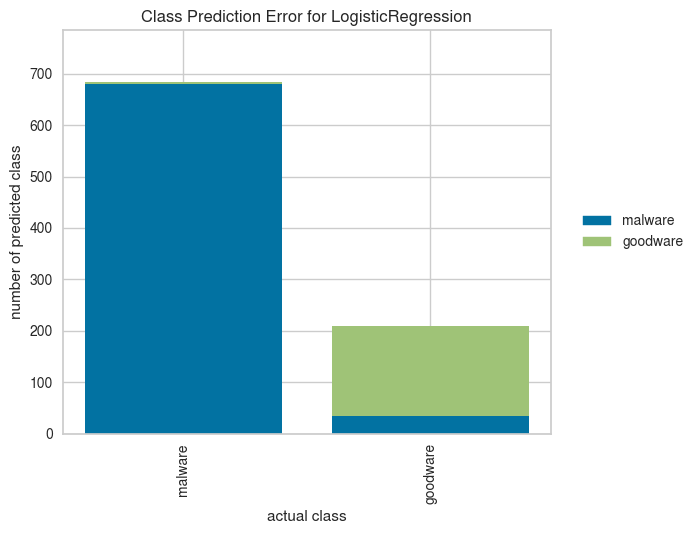

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


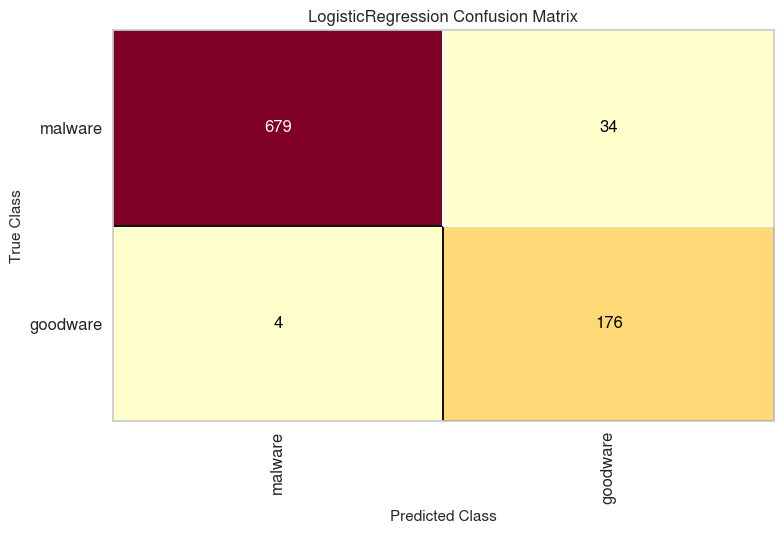

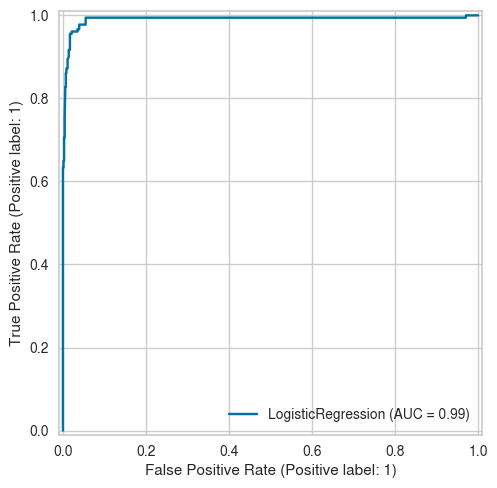


Logistic Regression Results:
Time: 86 ms
F1 Score: 0.96
MCC Score: 0.88
Precision: 0.96



In [ ]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=imputed_inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_NullData.append(logreg)

#### 2. Logistic Regression - sporcare i dati meno significativi

Per prima cosa generiamo nuove variabili di train e test che partono dal dataset contenente tutte le feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

Inseriamo dunque dei valori nulli solo all'interno delle colonne meno significative. 

Per fare ciò partiamo a generare una copia del dataset nelle quali colonne andremo ad inserire i valori nulli, ma solo se queste feature sono comprese nella variabile `less_important_features`

<Axes: >

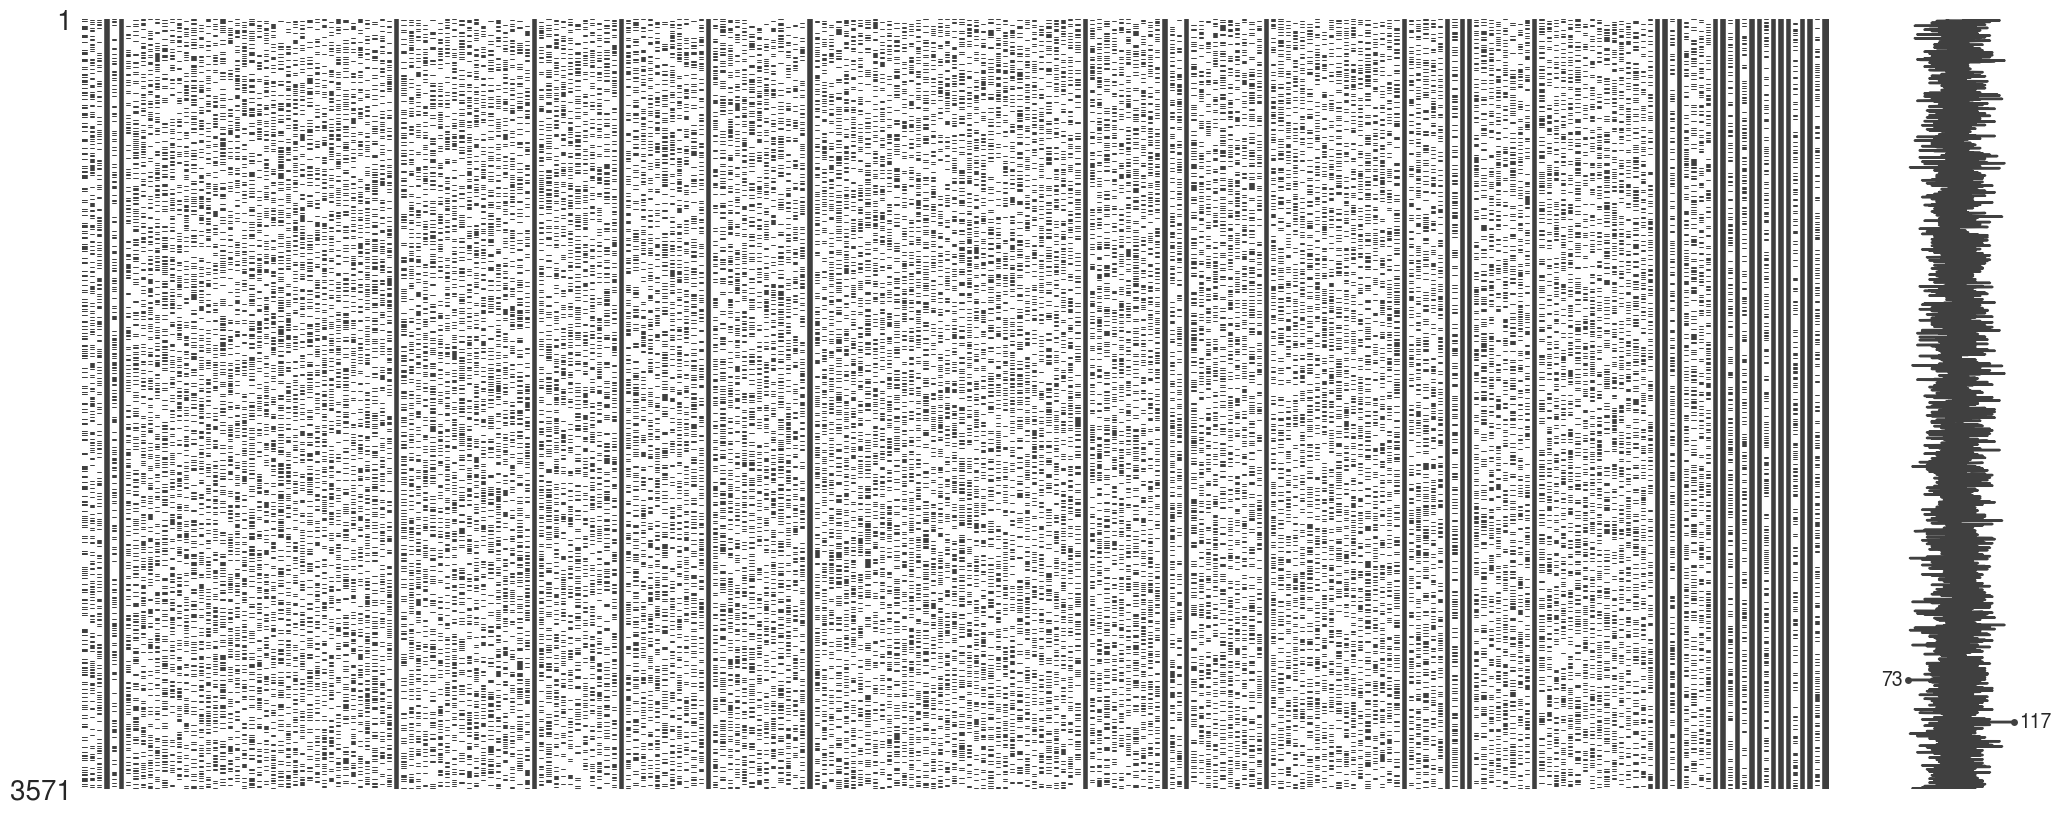

In [ ]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
inconsistent_uni_feature = insert_nulls(X_train=inconsistent_uni_feature, features_names=less_important_features, null_percentage=actual_pecentage)

# visualizzazione valori nulli
msno.matrix(inconsistent_uni_feature)

Dalla visual appena mostrata riusciamo a vedere quanto abbiamo sporcato il dataset. Tutte le colonne contengono ora per il `actual_pecentage`% valori mancanti, trnane le 14 colonne più importanti, che sono le colonne rappresentate dalle righe completamente nere, ossia mantengono ancora tutti i valori. 

Ora procediamo con il refill dei valori nulli con la moda

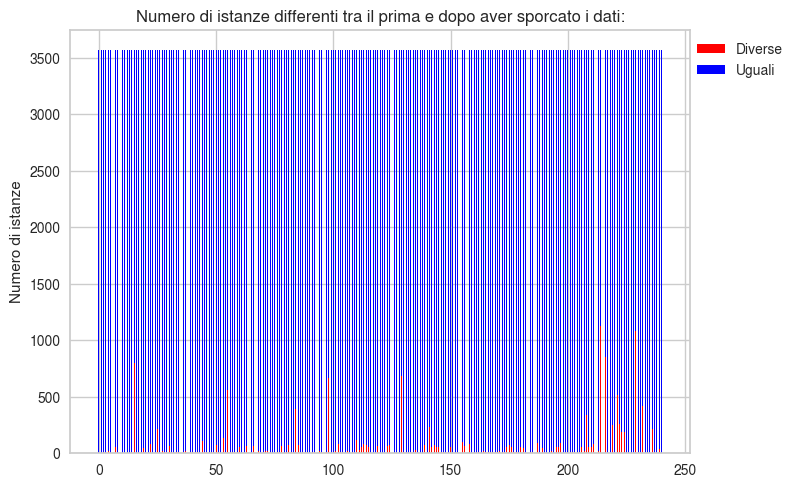

in totoale abbiamo che inserendo 70.0% di dati nulli
si ha che su 241 features abbiamo che solo 0 hanno più del 35.0% di dati sporchi


In [ ]:
# Crea un imputer che sostituisce i valori mancanti con la moda
imputer = SimpleImputer(strategy='most_frequent')

# Addestra l'imputer sui dati di addestramento
imputer.fit(inconsistent_uni_feature)

# Imputa i valori mancanti 
imputed_inconsistent_uni_feature = pd.DataFrame(imputer.transform(inconsistent_uni_feature), columns=inconsistent_uni_feature.columns)
imputed_inconsistent_uni_feature.index = X_train.index

# Visualizziamo come sono cambiati i dati dopo l'inserimento di dati nulli e l'imputing:
pcx = 0.35
n_feature_sotto_percentuale = len(visualize_difference(X_train, imputed_inconsistent_uni_feature,pcx))

print(f"in totoale abbiamo che inserendo {actual_pecentage*100}% di dati nulli")
print(f"si ha che su {len(X_train.columns)} features abbiamo che solo {len(X_train.columns) - n_feature_sotto_percentuale} hanno più del {pcx*100}% di dati sporchi")

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


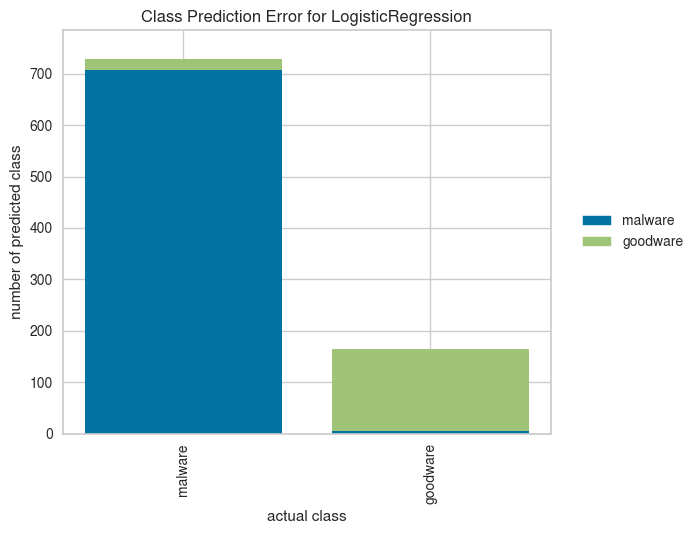

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


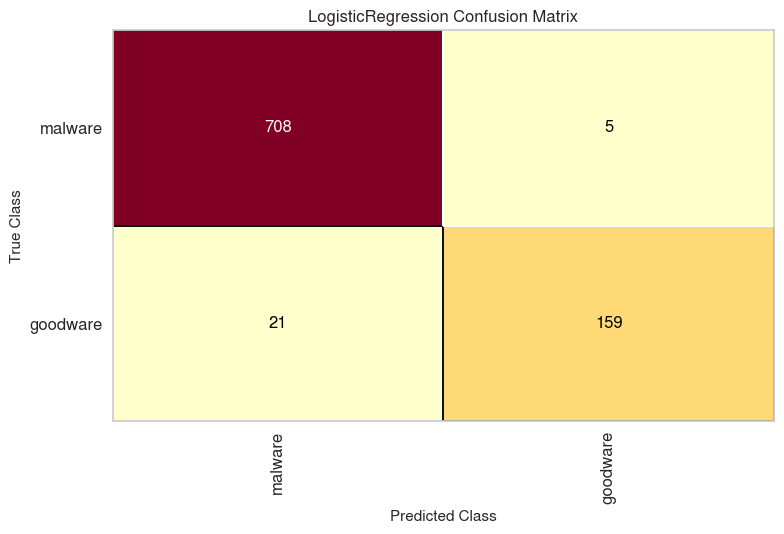

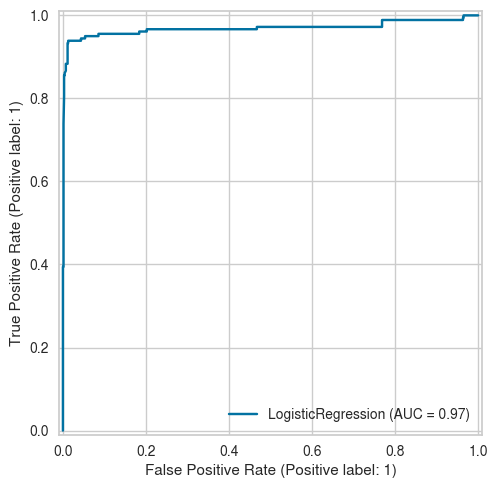


Logistic Regression Results:
Time: 69 ms
F1 Score: 0.97
MCC Score: 0.91
Precision: 0.97



In [ ]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=imputed_inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_NullData.append(logreg)

#### 3. Logistic Regression - sporcare le feature più significative (mantenendo altre feature)

Per prima cosa generiamo nuove variabili di train e test che partono dal dataset contenente tutte le feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

Inseriamo questa volta dei valori nulli solo all'interno delle colonne più significative per vedere la risposta del modello.

Per fare ciò partiamo a generare una copia del dataset nelle quali colonne andremo ad inserire i valori nulli, ma solo se queste feature sono comprese nella variabile `most_important_features_columns`

<Axes: >

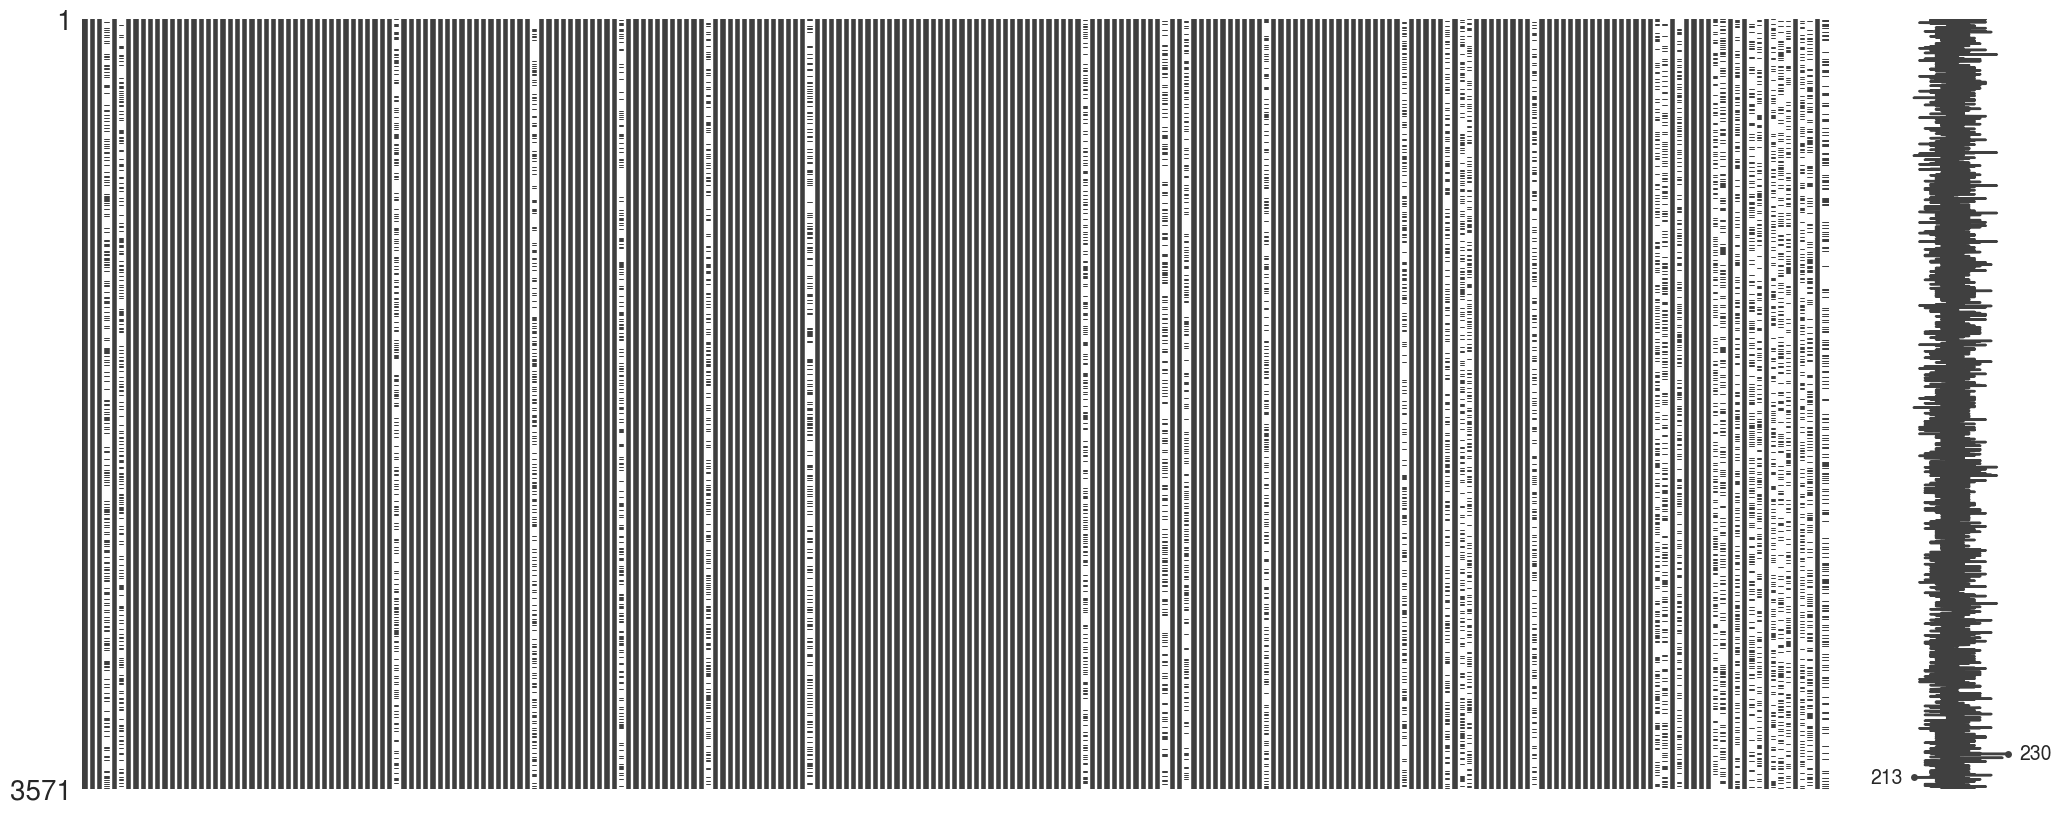

In [ ]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
inconsistent_uni_feature = insert_nulls(X_train=inconsistent_uni_feature, features_names=most_important_features_columns, null_percentage=actual_pecentage)

# visualizzazione valori nulli
msno.matrix(inconsistent_uni_feature)

Dalla visual appena mostrata riusciamo a vedere quanto abbiamo sporcato il dataset. 

Diversamente da prima ora la maggior parte delle colonne mantengono i loro dati intatti. Invece le colonne più significative contengono ora per il `actual_pecentage` valori mancanti.

Ora procediamo con il refill dei valori nulli con la moda

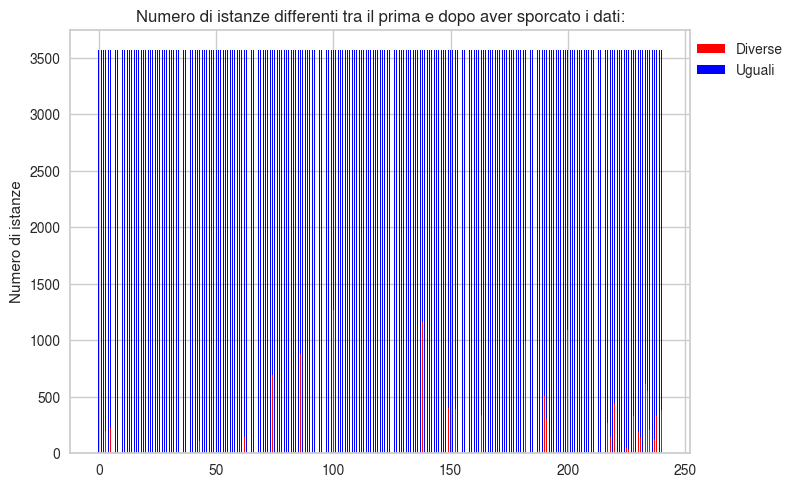

in totoale abbiamo che inserendo 70.0% di dati nulli
si ha che su 241 features abbiamo che solo 1 hanno più del 35.0% di dati sporchi


In [ ]:
# Crea un imputer che sostituisce i valori mancanti con la moda
imputer = SimpleImputer(strategy='most_frequent')

# Addestra l'imputer sui dati di addestramento
imputer.fit(inconsistent_uni_feature)

# Imputa i valori mancanti 
imputed_inconsistent_uni_feature = pd.DataFrame(imputer.transform(inconsistent_uni_feature), columns=inconsistent_uni_feature.columns, index=X_train.index)
imputed_inconsistent_uni_feature.index = X_train.index

# Visualizziamo come sono cambiati i dati dopo l'inserimento di dati nulli e l'imputing:
pcx = 0.35
n_feature_sotto_percentuale = len(visualize_difference(X_train, imputed_inconsistent_uni_feature,pcx))

print(f"in totoale abbiamo che inserendo {actual_pecentage*100}% di dati nulli")
print(f"si ha che su {len(X_train.columns)} features abbiamo che solo {len(X_train.columns) - n_feature_sotto_percentuale} hanno più del {pcx*100}% di dati sporchi")

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


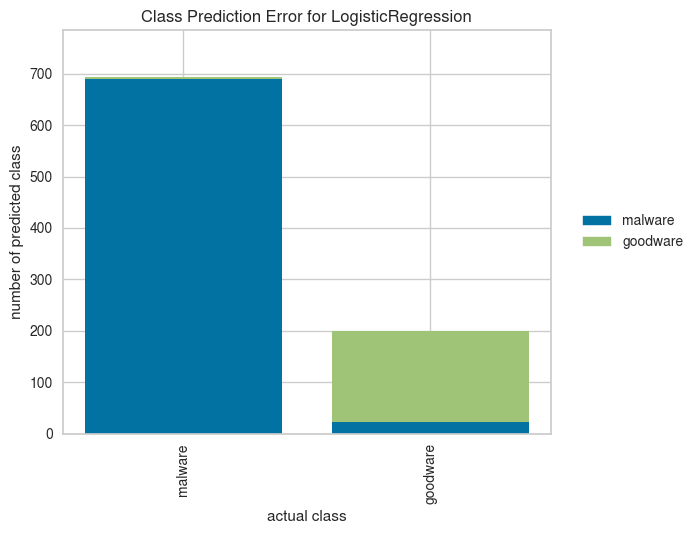

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


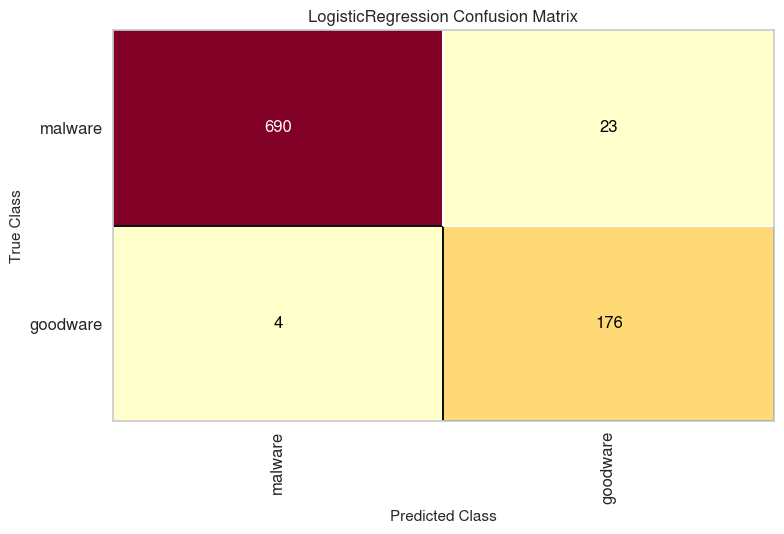

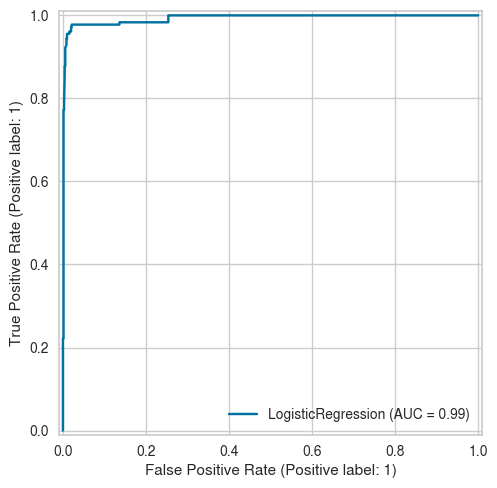


Logistic Regression Results:
Time: 121 ms
F1 Score: 0.97
MCC Score: 0.91
Precision: 0.97



In [ ]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=imputed_inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_NullData.append(logreg)

#### 4. Logistic Regression - sporcare le feature più significative (senza altre feature)

In questo caso partimo direttamente generare dati di train e test dal dataset che contiene solo le feature più importanti `most_important_features` e poi andremo a sporcarle tutte

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.20, random_state=42, stratify=uni_target) 

<Axes: >

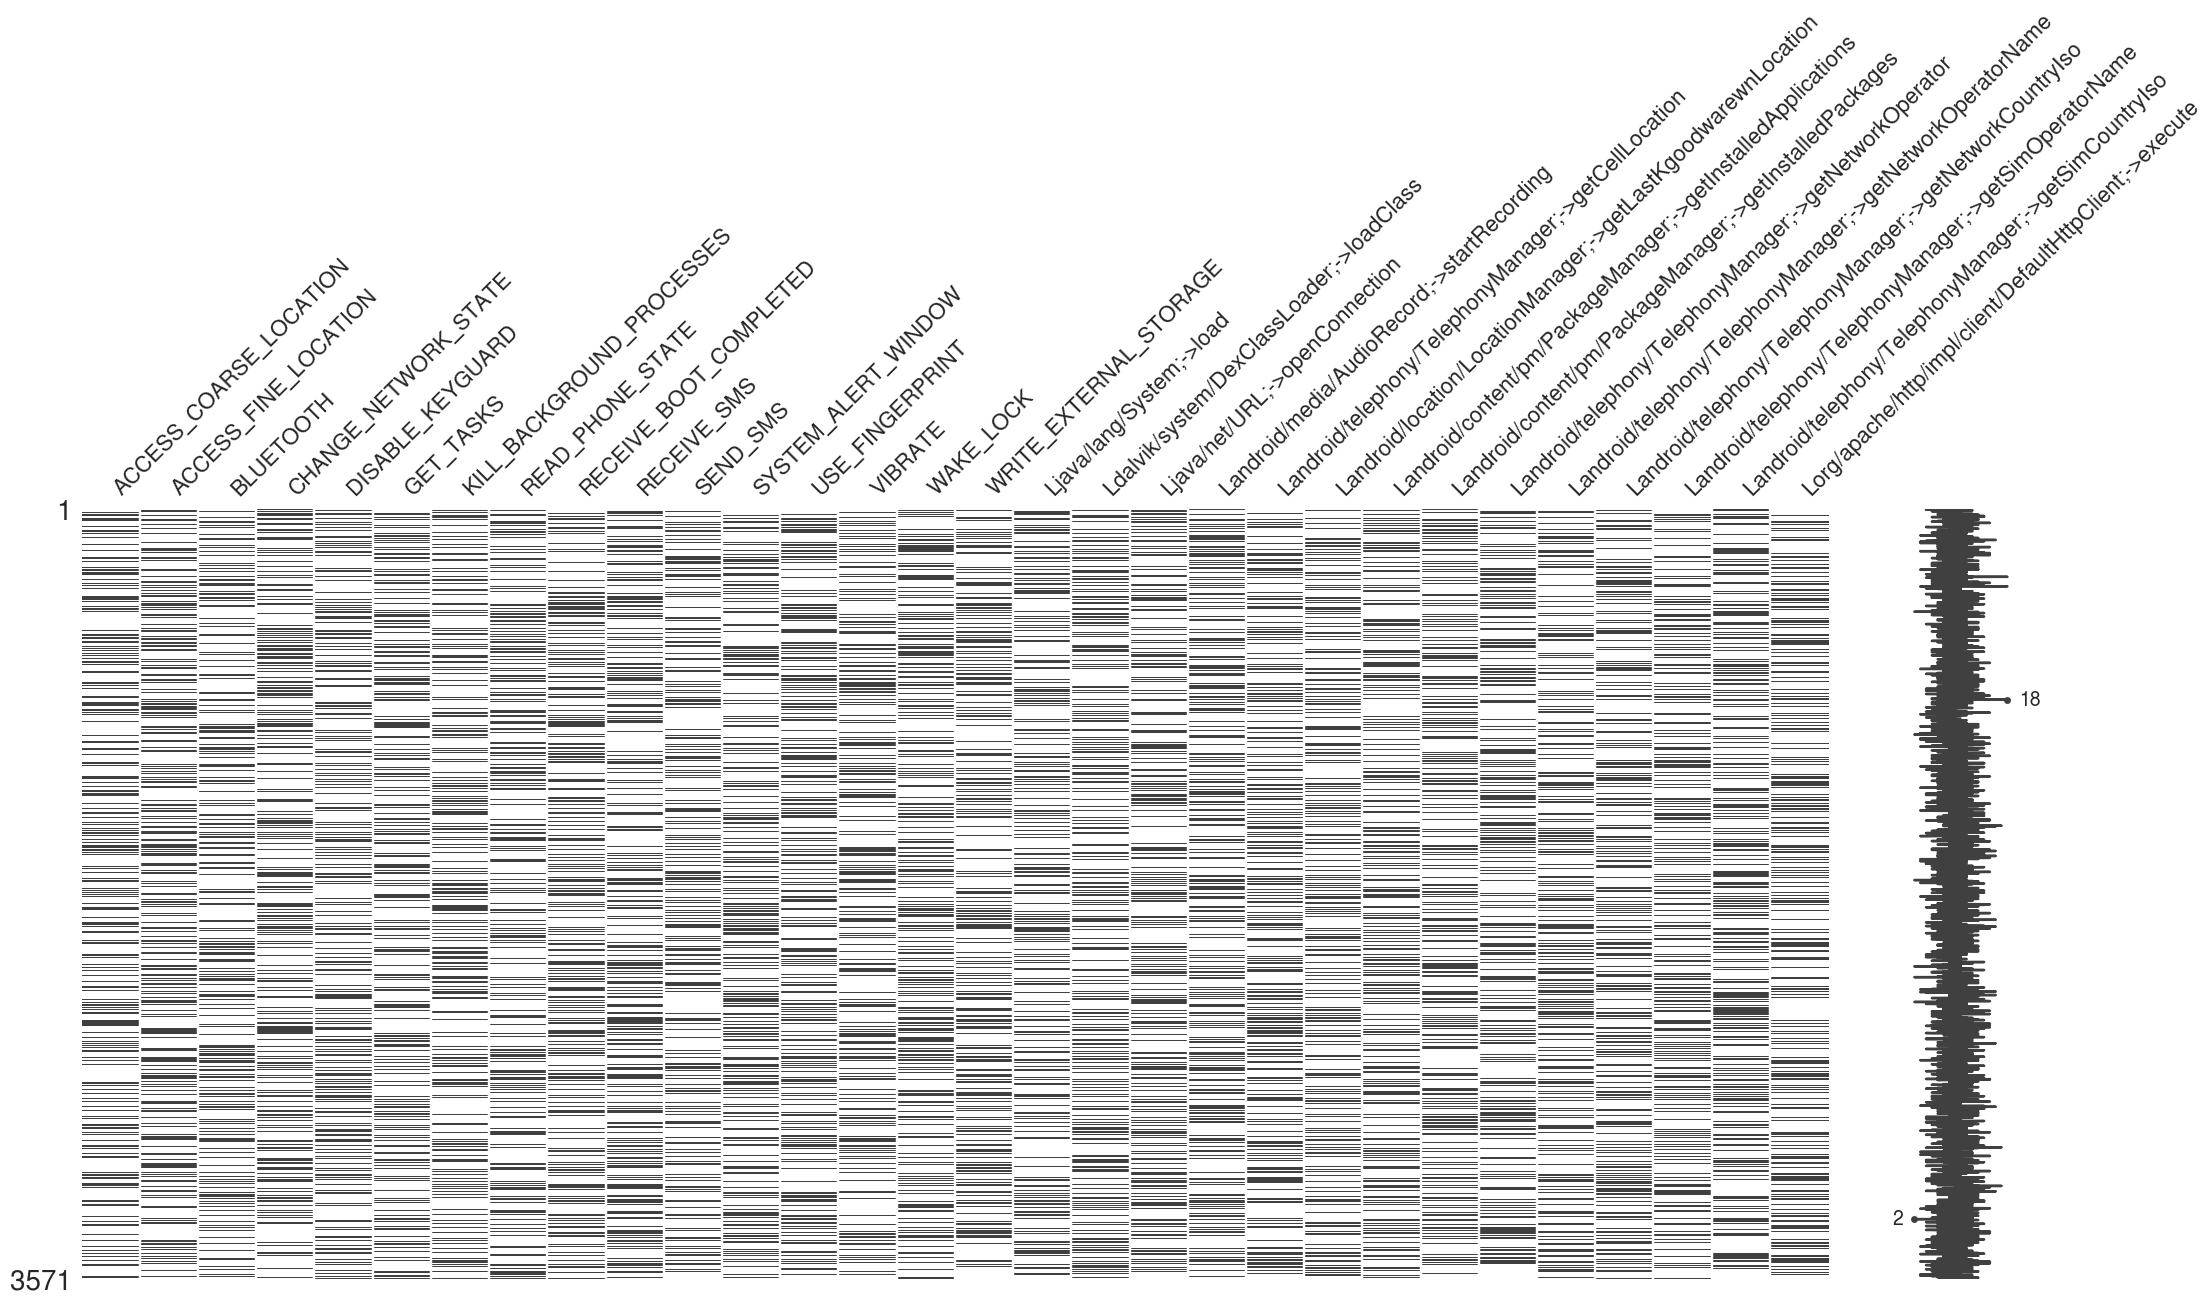

In [ ]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = X_train.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
inconsistent_uni_feature = insert_nulls(X_train=inconsistent_uni_feature, features_names=most_important_features_columns, null_percentage=actual_pecentage)

# visualizzazione valori nulli
msno.matrix(inconsistent_uni_feature)

Abbiamo tenuto solo le colonne più significative ma ora tutte le colonne ora contengono ora per il `actual_pecentage` valori mancanti

Ora procediamo con il refill dei valori nulli con la moda

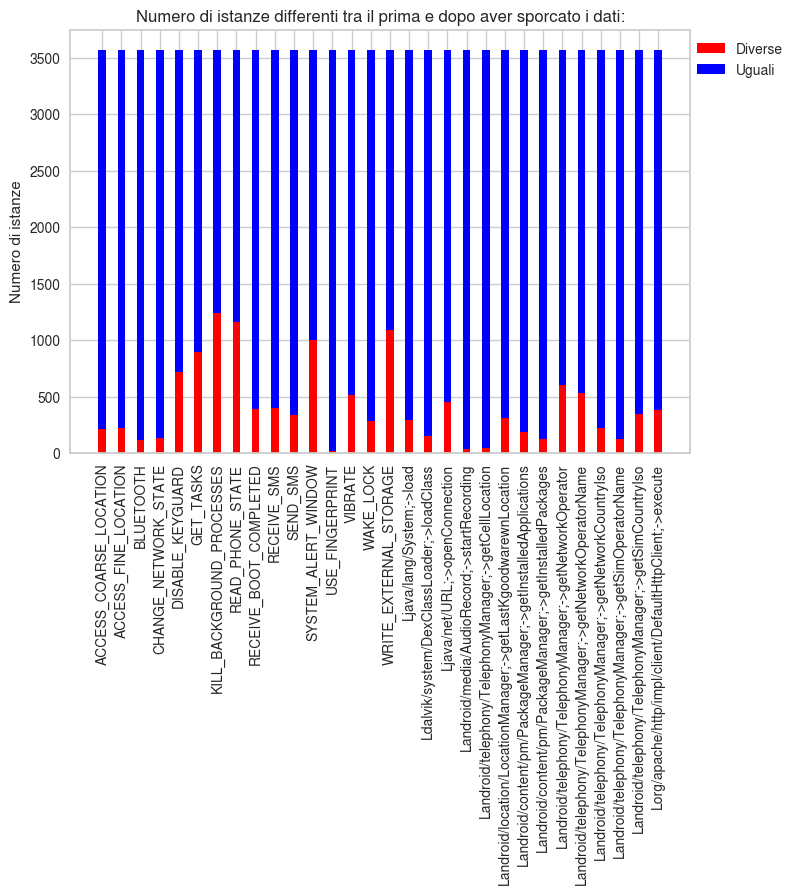

in totoale abbiamo che inserendo 70.0% di dati nulli
si ha che su 30 features abbiamo che solo 0 hanno più del 35.0% di dati sporchi


In [ ]:
# Crea un imputer che sostituisce i valori mancanti con la moda
imputer = SimpleImputer(strategy='most_frequent')

# Addestra l'imputer sui dati di addestramento
imputer.fit(inconsistent_uni_feature)

# Imputa i valori mancanti 
imputed_inconsistent_uni_feature = pd.DataFrame(imputer.transform(inconsistent_uni_feature), columns=inconsistent_uni_feature.columns)
imputed_inconsistent_uni_feature.index = X_train.index

# Visualizziamo come sono cambiati i dati dopo l'inserimento di dati nulli e l'imputing:
pcx = 0.35
n_feature_sotto_percentuale = len(visualize_difference(X_train, imputed_inconsistent_uni_feature,pcx))

print(f"in totoale abbiamo che inserendo {actual_pecentage*100}% di dati nulli")
print(f"si ha che su {len(X_train.columns)} features abbiamo che solo {len(X_train.columns) - n_feature_sotto_percentuale} hanno più del {pcx*100}% di dati sporchi")

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del nuovo modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


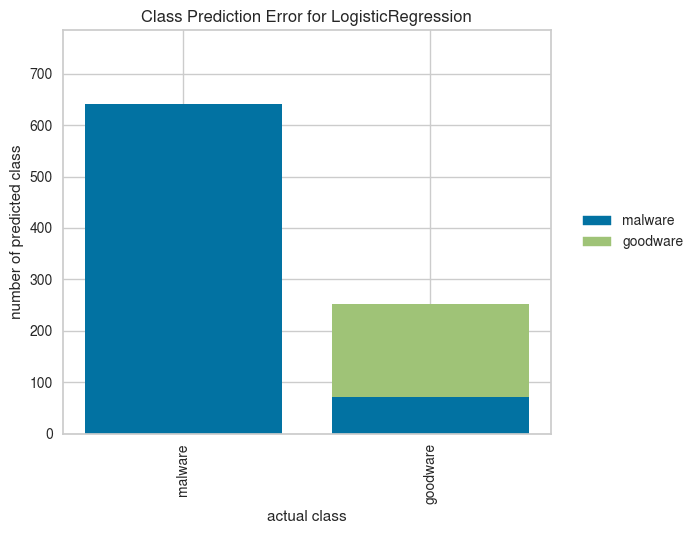

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


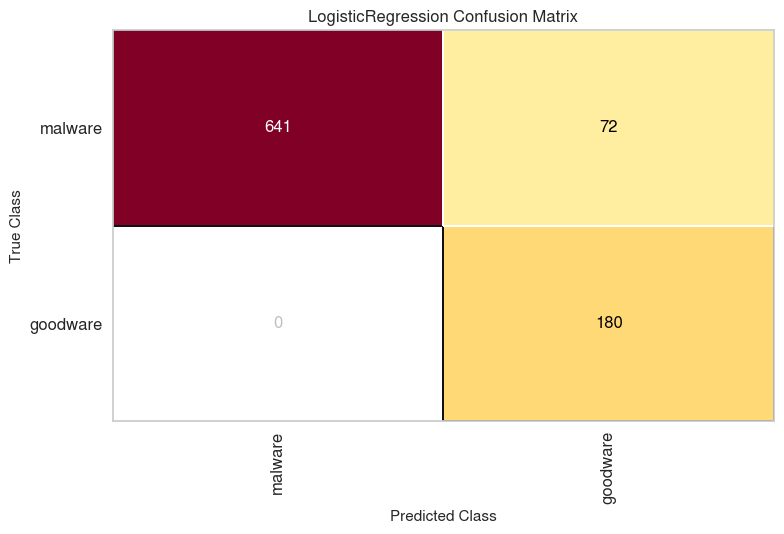

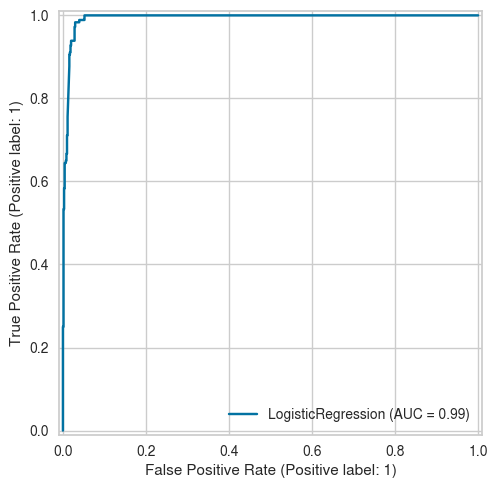


Logistic Regression Results:
Time: 22 ms
F1 Score: 0.92
MCC Score: 0.80
Precision: 0.92



In [ ]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(train_df=imputed_inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["logreg"]
print_results_logreg(logreg)

# salvo il risultato nella lista
post_elaboration_result_NullData.append(logreg)

#### 5. Naive Bayes - sporcare le feature più significative  (senza altre feature)

Siccome abbiamo già creato per il modello precedete una copia del dataset che contiene solo le feature più importanti `most_important_features` e queste sono anche già state sporcate possiamo direttamente procedere con la valutazione dei dati per vedere come si comporta il modello:


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


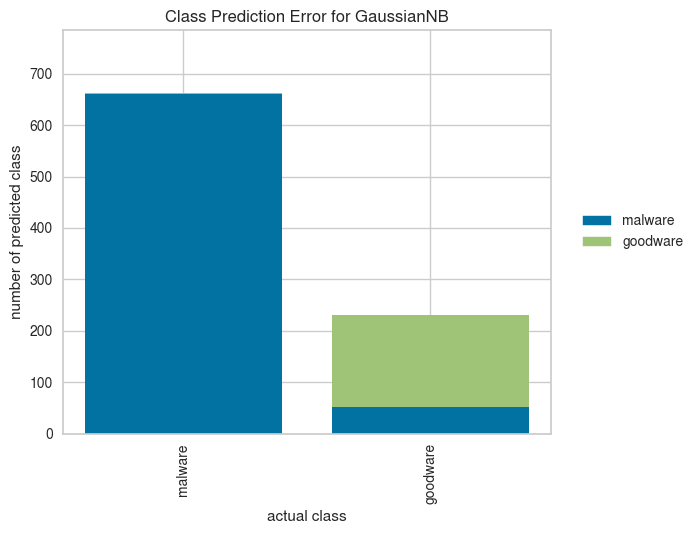

/home/Cava/Documents/Repos/Notebooks/Progetto Architettura Dati/Goodware-vs-Malaware-machine-learning/.venv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


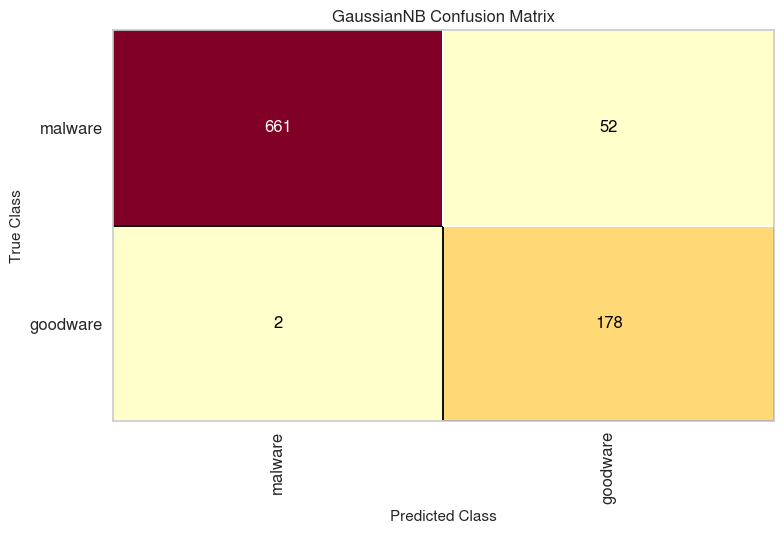

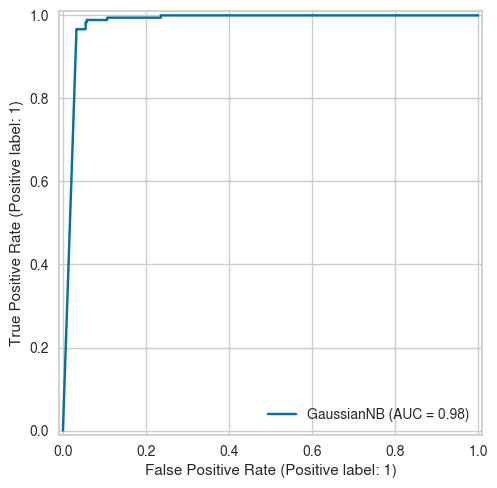


Naive Bayes Results:
Time: 11 ms
F1 Score: 0.94
MCC Score: 0.84
Precision: 0.94



In [ ]:
# valutazione tramire Naive Bayes delle nuove performance
nb = evaluate_with_Naive_Bayes(train_df=imputed_inconsistent_uni_feature, train_target=y_train, test_df=X_test, test_target=y_test)["naive_bayes"]
print_results_nb(nb)

# salvo il risultato nella lista
post_elaboration_result_NullData.append(nb)

#### 6. Brevi concusioni

Notiamo che generalmente le performance di classificazione non diminuiscono quasi per niente nei primi 3 punti, questo è facilmente spiegabile dal fatto che usando comunque tutto il dataset abbiamo che solo pochissime colonne subiscono una variazia molto significativa (più del 35% di dati differenti), anche aumentando di molto la percentuale di dati sporchi. 

E l'avere il così poche colonne con dati differenti è dovuto al fatto che probabilmente in molte di queste colonne è presente per la maggior parte solo 0 oppure solo 1. Quindi sostituendo con la moda diventa facile capire come queste feature dopo aver fatto l'imputing non abbiano una variazione del neanche 35%. 

Inoltre, come abbiamo già visto precedentemente con la sostituzione dei dati casuali, se non abbiamo abbastanza colonne sporche i modelli si possono basare semplicemente sulle colonne più "pulite" per fare la predizione, in questo modo si riesce comunque a raggiungere un alto livello di precisione.

Nei punti 4 e 5 invece la sostituzione con dati casuali diventa molto più influente e in certi casi (sporcando all'85%) si arriva anche ad osservare peggioramento delle performance abbastanza significativo: 

- il cambiamento nei risultati può essere considerato può oscillare tra il significativo e non molto significativo, in quanto abbiamo perso quasi il tra il 10% ed il 40% di MCC score ed il 5-20% circa di precisione ed f1-score rispetto al baseline model (`trained_logreg_important_features`). Qquesti valori cambiano a seconda della run, siccome è impossibile prevedere come il metodo di inserimento di valori nulli si comporterà. 
- allo stesso tempo il cambiamento può essere considerato come MOLTO significativo perchè generalmente aumenta di molto il numero di istanze di malware erroneamente classifiate come goodware e questo è un caso sicuramente è un molto più importante ed incisivo sullo studio che stiamo facendo piuttosto che quando invece dei goodware vengono classificati come malaware (se un buon software viene etichettato come malvagio è solo un falso allarme, non succederebbe nulla ad un ipotetico enduser, nel caso opposto, se un malware viene classifcato come goodware allora il nostro ipotetico enduser mette la sua macchina a rischio perchè potrebbe installare dei programmi malware che non gli sono stati segnalati come tali). 
Dunque non sarebbe giusto accettare di avere performance del genere: perchè la maggior parte degli errori di classificazione è su malaware che vengono etichettati come goodware.

Infatti se mostriamo in un grafico come variano le statistiche di accuratezza, f1-score e mcc-score vediamo che generalmente dei punti dal 2 in poi dovremmo osservare che (generalmente) diminuiscono gradualmente:

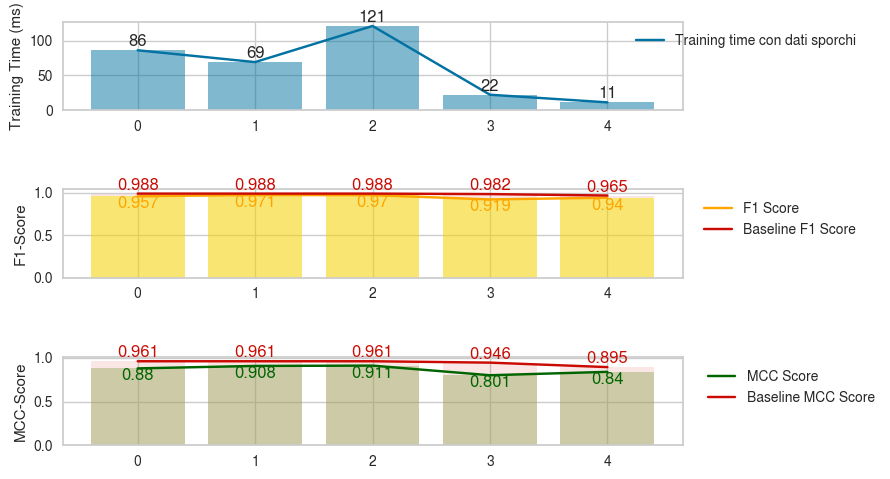

In [ ]:
evaluate_overall_performance(post_elaboration_result_NullData)

##### Considerazioni sul decadimento delle performance tra baseline e modelli con dati sporchi:

Nota che i risultati mostrati ci piacciono perchè, come abbiamo già dimostrato prima (sporcando i dati inserendo valori casuali), mettendo a paragone le performance di classificazione (f1-score e mcc-score) tra baseline e modello addestrato non abbiamo una grossa differenza perchè anche qui perchè, come è visibile da tutti i grafici che mostrano le differenze tra il dataset prima e dopo averlo sporcato, pur inserendo un grosso numero di dati nulli l'imputer con la moda riesce a riscostruire molto bene i dati, abbiamo quindi in verità una percentuale molto bassa di dati sporchi che non ci fa' diminuire di molto le perfrormance da baseline a modello con dati sporchi. 

##### Considerazioni del decadimento delle performance passo-passo:

Nota che questo ha perfettamente senso che le perfonce diminuiscano gradualmente ad ogni nuova elaborazione in base a come abbiamo ordinato ordinato ogni elaborazione, perchè:
- nel primo caso usiamo logistic regression ma stiamo andando a modificare solo le feature meno significative (mantenendo tutte le feature), ci aspettiamo quindi un buon risultato di predizione
- nel secondo caso usiamo sempre logistic regression stiamo andando a modificare solo le feature più significative (mantenendo tutte le altre feature). Ha quindi perfettamente senso che le performance di classificazione diminuiscano, ha anche perfettamente senso che le performance non diminuiscano comunque di molto perchè abbiamo orsservato in precedenza che ci sono molte colonne con lo stesso valore informativo. Non ci sorprende nemmeno che il tempo di elaborazione aumenti dallo step precedente in quanto qesto step è stato fatto con logstic regression che utilizza un metodo ricorsivo su ogni feature, se gli si sporcano le feature più importanti allora andrà a cercare l'informazione che gli serve in altre feature (aumentando però il numero di ricorsioni, ossia il tempo aumenta)
- nel terzo caso si usa logistic regression sporcando tutte le celle di tutte le feature: ha senso che le performance siano peggiorate rispetto al caso precedente a livello di predizione in quanto ora tutte le celle contengono dati sporchi, quindi i modelli che prima potevano cercare la stessa informazine in altre colonne ora sono "costretti" ad imparare per forza dai dati sporchi. Ha anche senso che, come vediamo, le performance comunque non diminuiscano di molto sempre per la ragione del fatto che anche sporcando una alta quantità di dati molti rimango intatti per puro caso. Ha anche perfettamente senso che questo sia il caso con il training time più alto in quanto avendo un grosso numero di colonne e molti più dati sporchi rispetto agli altri esempi la logistic regression dovrà fare molte più iterazioni.
- nel quarto caso si usa ancora logistic regression e si sporcano le feature più significative (mantenendo però nel dataset solo ed esclusivamente le feature più significative). Ha quindi perfettamente senso che in questo caso le performance di classificazione peggiorino rispetto allo step precedente, perchè non ci sono più le altre colonne che potrebbero contenere lo stesso valore informativo, quindi se un dato viene sporcato in questa particolare istanza del problema ha molto più peso rispetto al caso precedente e le conseguenze si riperquotono su f1-score e mcc-score. Ha anche perfettamente senso che il tempo di valutazione si riduca drasticamente in qunato stiamo utlizzando molte meno features
- nell'ultimo caso invece stiamo usando il modello di naive bayes e si sporcano le feature più significative (mantenendo però nel dataset solo ed esclusivamente le feature più significative). Ha senso che rispetto al caso precedente si registri un calo di performance nella classificazione (anche se piccolo) perchè abbiamo già dimostrato che il modello naive bayes è più soggetto a bias rispetto alla regressione logistica. Nota che però (a volte può capitare comunque che il modello di naive bayes si comporti meglio di quello della logistic regression, dipende sempre dalla run). Essendo però naive bayes un algoritmo molto più leggero ha anche perfettamente senso che diminuiscano i tempi di computazione 